<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs)

**GitHub Repository**: https://github.com/jiaminho/RPH-HAC-Prediction/tree/main

 **MIMIC-III**
- https://mimic.mit.edu/docs/iii/
- https://physionet.org/content/mimiciii/1.4/
- schema: https://mit-lcp.github.io/mimic-schema-spy/index.html

MIMIC-III is a relational database consisting of 26 tables. Tables are linked by identifiers which usually have the suffix ‘ID’. For example, SUBJECT_ID refers to a unique patient, HADM_ID refers to a unique admission to the hospital, and ICUSTAY_ID refers to a unique admission to an intensive care unit.

Five tables are used to define and track patient stays: ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS. Another five tables are dictionaries for cross-referencing codes against their respective definitions: D_CPT; D_ICD_DIAGNOSES; D_ICD_PROCEDURES; D_ITEMS; and D_LABITEMS. The remaining tables contain data associated with patient care, such as physiological measurements, caregiver observations, and billing information.

- mimic code repository: https://github.com/MIT-LCP/mimic-code
- mimic paper: https://www.nature.com/articles/sdata201635
- mimic website github: https://github.com/MIT-LCP/mimic-website
- mimic paper github: https://github.com/MIT-LCP/mimic-iii-paper/tree/master

HAC list: https://www.safetyandquality.gov.au/publications-and-resources/resource-library/hospital-acquired-complications-hacs-list-specifications-version-31-12th-edn

**Import necessary libraries**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Dense
# import umap

**Read files**

In [ ]:
d_cpt = pd.read_csv('data/D_CPT.csv')               # 16K
d_labitems = pd.read_csv('data/D_LABITEMS.csv')       # 44K
caregivers = pd.read_csv('data/CAREGIVERS.csv')     # 200K
d_icd_procedures = pd.read_csv('data/D_ICD_PROCEDURES.csv') #300K
d_items = pd.read_csv('data/D_ITEMS.csv')           # 936K
d_icd_diagnoses = pd.read_csv('data/D_ICD_DIAGNOSES.csv') # 1.4M
patients = pd.read_csv('data/PATIENTS.csv')         # 2.6M
services = pd.read_csv('data/SERVICES.csv')         # 3.4M
callout = pd.read_csv('data/CALLOUT.csv')           # 6.1M
icustays = pd.read_csv('data/ICUSTAYS.csv')         # 6.1M
procedures_icd = pd.read_csv('data/PROCEDURES_ICD.csv')  # 6.5M
drgcodes = pd.read_csv('data/DRGCODES.csv')         # 11M
admissions = pd.read_csv('data/ADMISSIONS.csv')      # 12M
diagnoses_icd = pd.read_csv('data/DIAGNOSES_ICD.csv')   # 19M
transfers = pd.read_csv('data/TRANSFERS.csv')       # 24M
procedureevents_mv = pd.read_csv('data/PROCEDUREEVENTS_MV.csv') # 47M
cptevents = pd.read_csv('data/CPTEVENTS.csv') # 56M
microbiologyevents = pd.read_csv('data/MICROBIOLOGYEVENTS.csv')  # 70M
outputevents = pd.read_csv('data/OUTPUTEVENTS.csv')  # 379M
datetimeevents = pd.read_csv('data/DATETIMEEVENTS.csv') # 502M
prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv') # 735M
inputevents_mv = pd.read_csv('data/INPUTEVENTS_MV.csv') # 931M
labevents = pd.read_csv('data/LABEVENTS.csv')       # 1.8G
inputevents_cv = pd.read_csv('data/INPUTEVENTS_CV.csv') # 2.3G
noteevents = pd.read_csv('data/NOTEEVENTS.csv')     # 3.5G

/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_21449/2829899166.py:17: DtypeWarning: Columns (4,5,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  cptevents = pd.read_csv('data/CPTEVENTS.csv') # 56M
/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_21449/2829899166.py:20: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  datetimeevents = pd.read_csv('data/DATETIMEEVENTS.csv') # 502M
/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_21449/2829899166.py:21: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv') # 735M
/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_21449/2829899166.py:24: DtypeWarning: Columns (7,9,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  inputevents_cv = pd.read_csv('data/INPUTEVENTS_CV.csv') # 2.3G
/

<div class="alert alert-block alert-info">
<h2>Exploratory Data Analysis and Data Cleaning</h2>
</div>


### 1. ADMISSIONS.csv

In [ ]:
admissions.head()

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [ ]:
admissions.shape

(58976, 19)

There are 58976 admissions with 19 variables

In [ ]:
missing_values = admissions.isnull().sum()
missing_values

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

53 122 values (~ 90.1%) are missing for Deathtime. These missing values likely represent those that survived and hence did not have a time of death. EDREGTIME and EDOUTTIME are both missing 28 099 values (~ 47.6%). 25 332 values (~ 43.0%) are missing for Language. 10 128 values (17.2%) are missing from Marital Status. 458 values (~ 0.8%) are missing for religion. Diagnosis is missing 25 values (~ 0.04%).

Fill NA values with missing.

In [ ]:
print("Number of Unique Values for Each Column")
for i in admissions.columns.tolist():
    unique_values = len(admissions[i].unique())
    print(f"{i}: {unique_values}")

Number of Unique Values for Each Column
ROW_ID: 58976
SUBJECT_ID: 46520
HADM_ID: 58976
ADMITTIME: 58651
DISCHTIME: 58657
DEATHTIME: 5835
ADMISSION_TYPE: 4
ADMISSION_LOCATION: 9
DISCHARGE_LOCATION: 17
INSURANCE: 5
LANGUAGE: 76
RELIGION: 21
MARITAL_STATUS: 8
ETHNICITY: 41
EDREGTIME: 30875
EDOUTTIME: 30865
DIAGNOSIS: 15692
HOSPITAL_EXPIRE_FLAG: 2
HAS_CHARTEVENTS_DATA: 2


There are 15692 unique values in the 'DIAGNOSIS' column.

Top 20 Most Common Admission Diagnoses

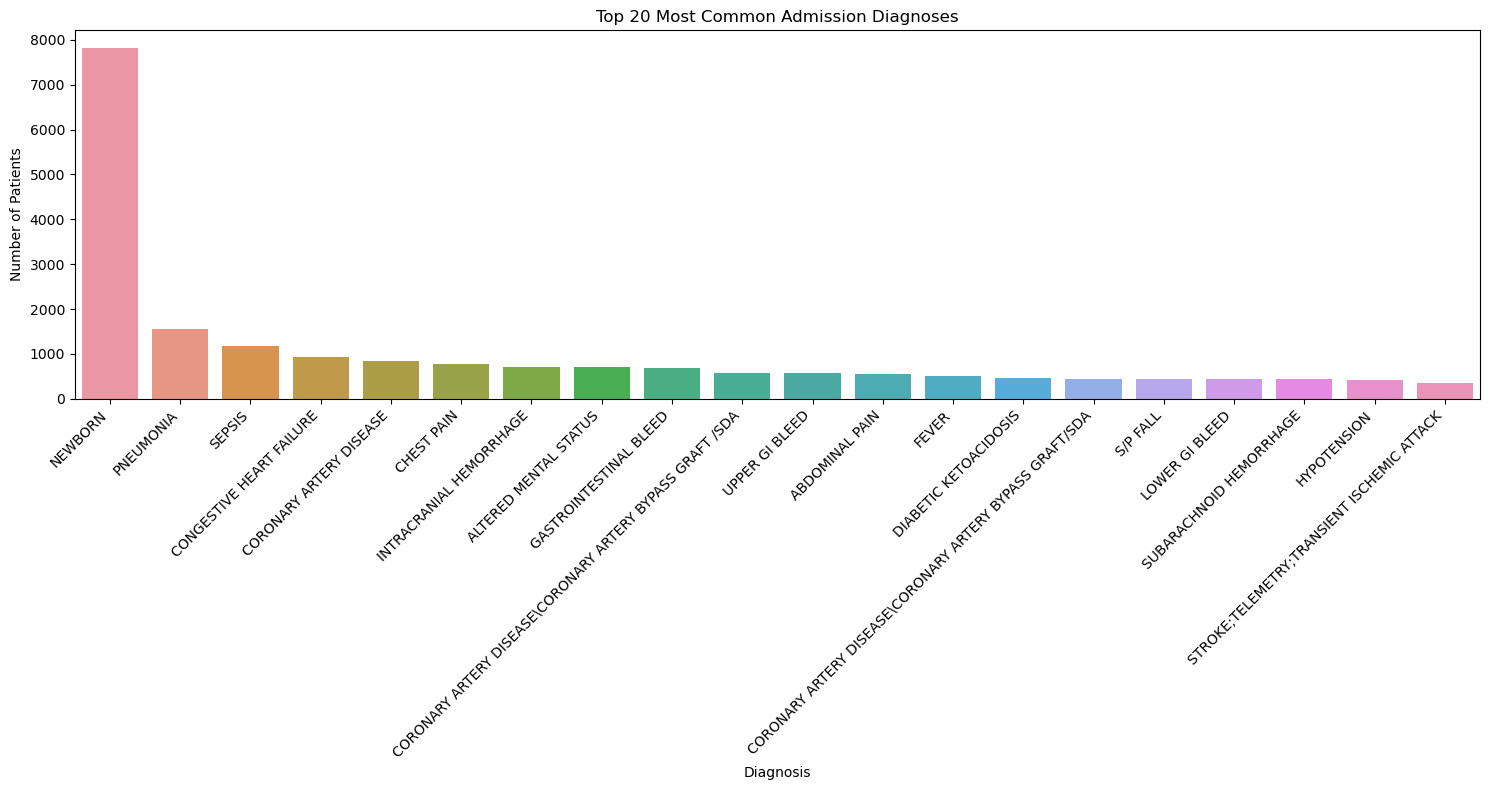

In [ ]:
# Count the occurrences of each diagnosis
diagnosis_counts = admissions['DIAGNOSIS'].value_counts()

# Take the top 20 most common diagnoses
top_diagnoses = diagnosis_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_diagnoses.index, y=top_diagnoses.values)
plt.title('Top 20 Most Common Admission Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the diagnosis names for better readability
plt.tight_layout()
plt.show()

Bar plot above shows the most common admission diagnoses.

In [ ]:
# function for plotting horizontal bar plots
def plot_categorical_data(column_name, df):
    plt.figure(figsize=(15, 8))
    sns.countplot(data=df, y=column_name, order = df[column_name].value_counts().index)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel('Number of Admissions')
    plt.tight_layout()
    plt.show()

# function for plotting verical bar plots
def plot_vertical_categorical_data(column_name, df, top_n, fontsize=8):
    df_counts = df[column_name].value_counts()
    top_X = df_counts.head(top_n)

    plt.figure(figsize=(5, 4))
    sns.barplot(x=top_X.index, y=top_X.values)

    plt.title('Top '+str(top_n)+' Most Common ' + column_name, fontsize=fontsize+2)
    plt.xlabel(column_name, fontsize=fontsize)
    plt.ylabel('Number of Admissions', fontsize=fontsize)
    plt.xticks(rotation=45, ha='right', fontsize=fontsize)  # Rotate the diagnosis names for better readability
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

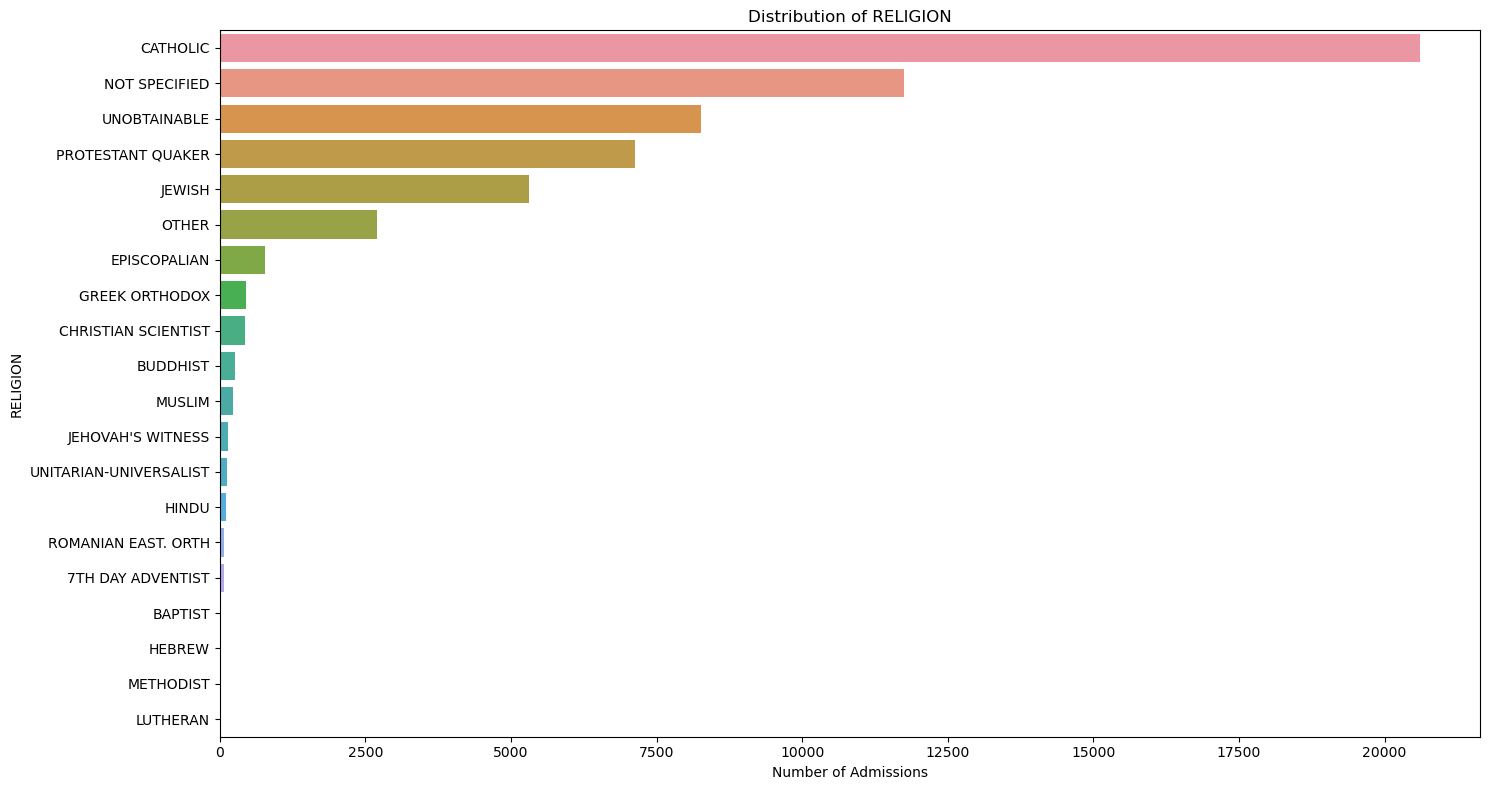

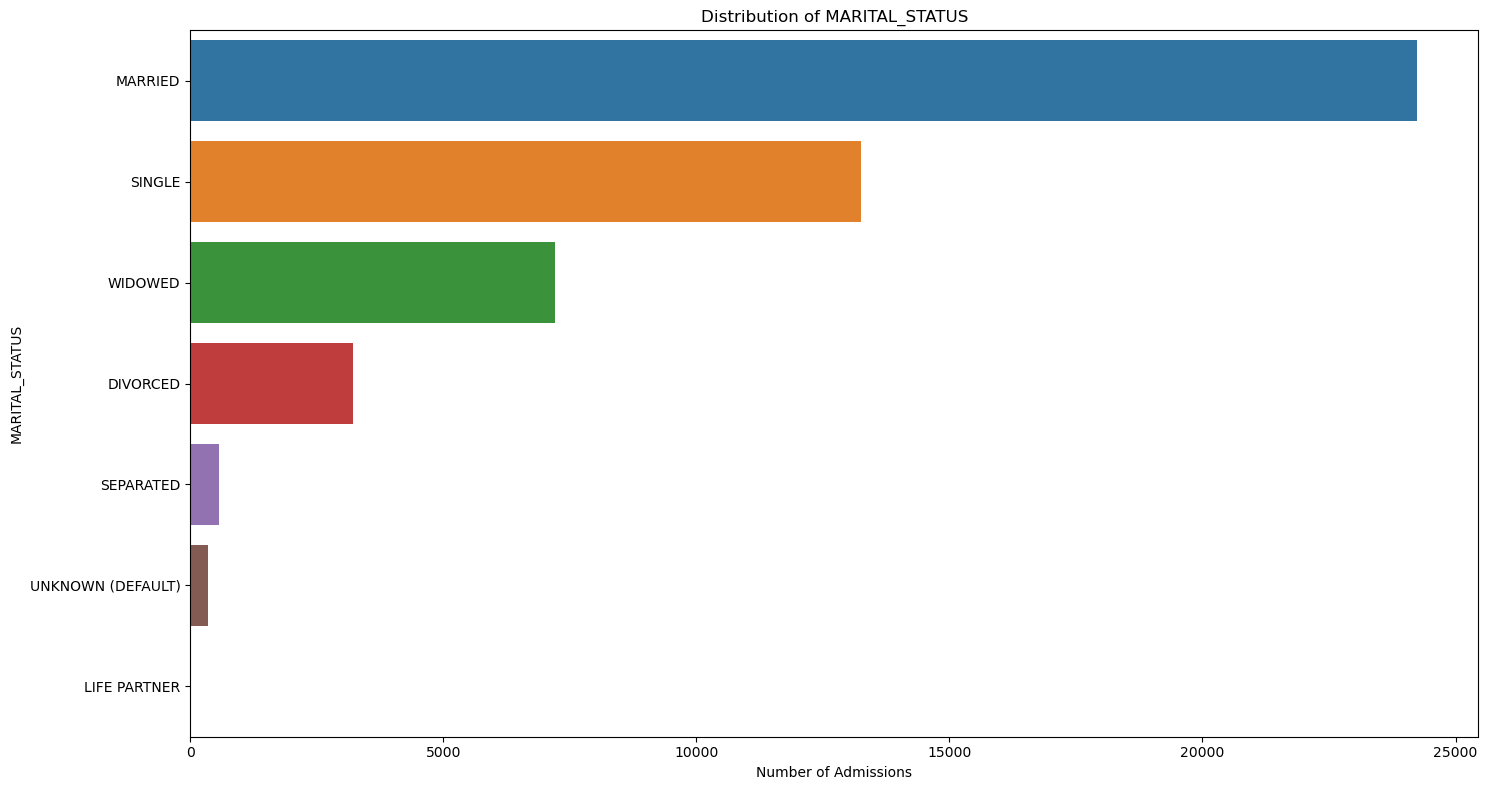

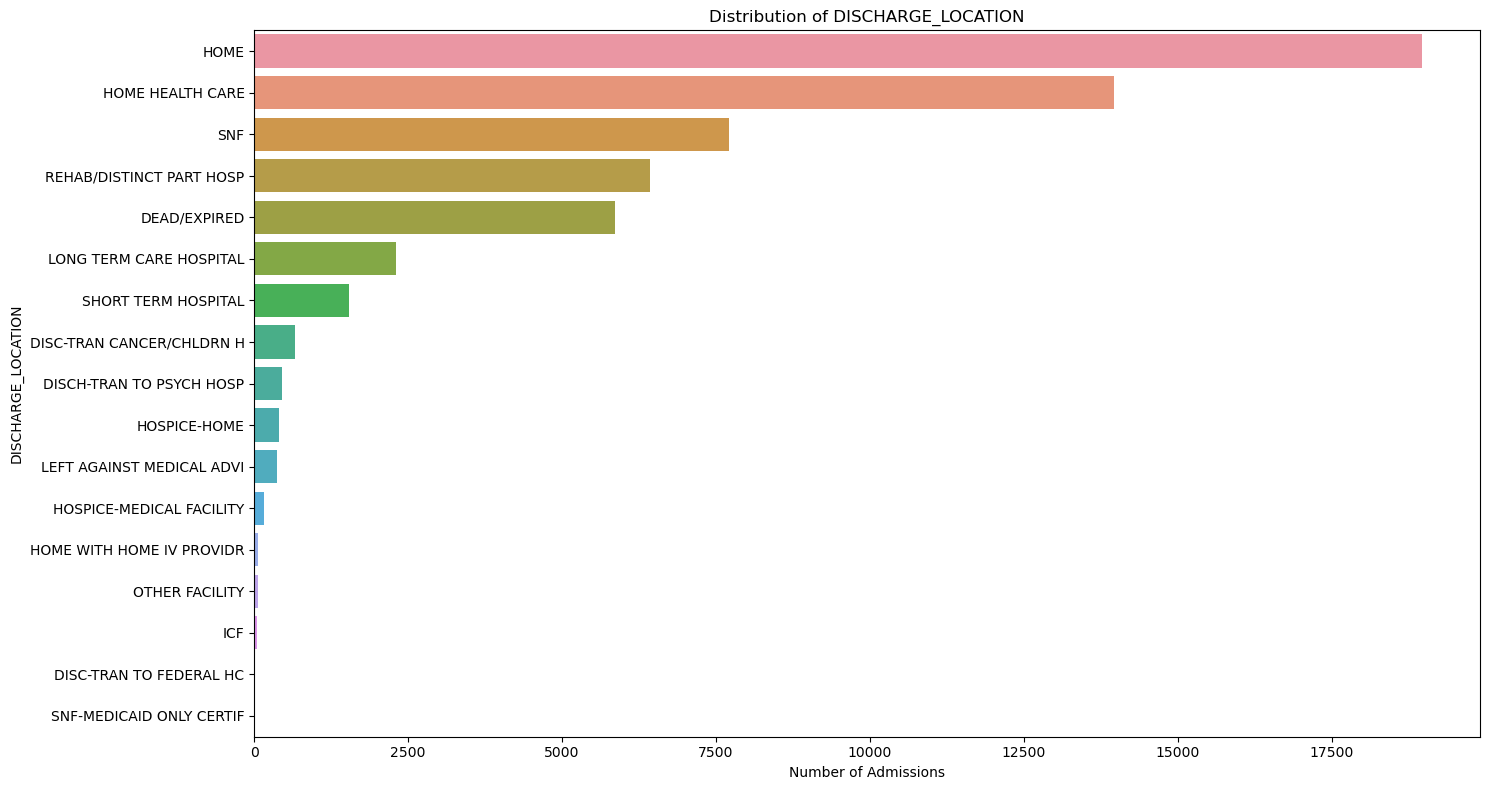

In [ ]:
# Visualizing each column
for column in ['RELIGION', 'MARITAL_STATUS', 'DISCHARGE_LOCATION',]:
    plot_categorical_data(column, admissions)

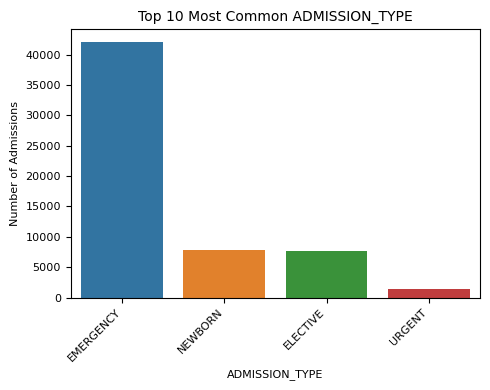

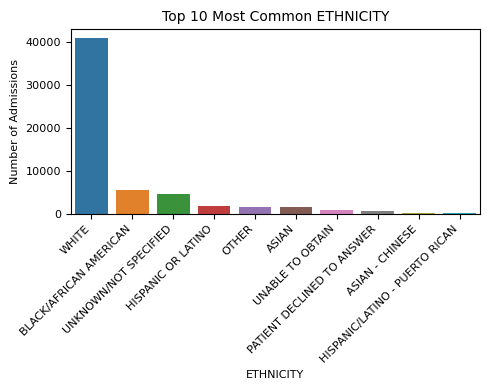

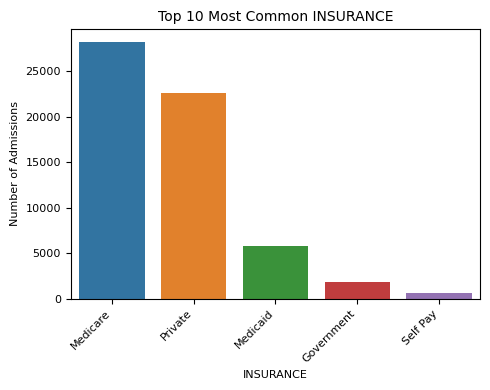

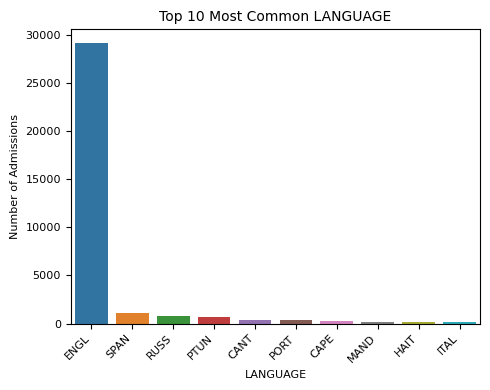

In [ ]:
for column in ['ADMISSION_TYPE', 'ETHNICITY', 'INSURANCE', 'LANGUAGE', ]:
    plot_vertical_categorical_data(column, df=admissions, top_n=10)

Visualize percentage of patients died

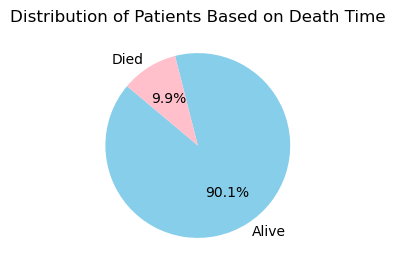

In [ ]:
# Create a new column 'DEATH_STATUS' to classify patients
admissions['DEATH_STATUS'] = admissions['DEATHTIME'].apply(lambda x: 'Died' if pd.notna(x) else 'Alive')

# Get the counts of each category
death_counts = admissions['DEATH_STATUS'].value_counts()

# Plot
plt.figure(figsize=(5,3))
plt.pie(death_counts, labels=death_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'pink'])
plt.title('Distribution of Patients Based on Death Time')
plt.show()

**Add admission_duration column**

In [ ]:
# calculate admission duration
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

admissions['admission_duration'] = admissions['DISCHTIME'] - admissions['ADMITTIME']

print(admissions['admission_duration'])

0        1 days 03:28:00
1        5 days 11:55:00
2        6 days 18:26:00
3        2 days 20:34:00
4        3 days 12:49:00
              ...       
58971    2 days 17:49:00
58972    0 days 13:10:00
58973    8 days 04:53:00
58974   41 days 10:42:00
58975    1 days 14:35:00
Name: admission_duration, Length: 58976, dtype: timedelta64[ns]


### 2. PATIENTS.csv

In [ ]:
patients

ROW_ID  SUBJECT_ID GENDER                  DOB                  DOD  \
0         234         249      F  2075-03-13 00:00:00                  NaN   
1         235         250      F  2164-12-27 00:00:00  2188-11-22 00:00:00   
2         236         251      M  2090-03-15 00:00:00                  NaN   
3         237         252      M  2078-03-06 00:00:00                  NaN   
4         238         253      F  2089-11-26 00:00:00                  NaN   
...       ...         ...    ...                  ...                  ...   
46515   31840       44089      M  2026-05-25 00:00:00                  NaN   
46516   31841       44115      F  2124-07-27 00:00:00                  NaN   
46517   31842       44123      F  2049-11-26 00:00:00  2135-01-12 00:00:00   
46518   31843       44126      F  2076-07-25 00:00:00                  NaN   
46519   31844       44128      M  2098-07-25 00:00:00                  NaN   

                  DOD_HOSP DOD_SSN  EXPIRE_FLAG  
0                      NaN     NaN            0  
1      2188-11-22 00:00:00     NaN            1  
2                      NaN     NaN            0  
3                      NaN     NaN            0  
4                      NaN     NaN            0  
...                    ...     ...          ...  
46515                  NaN     NaN            0  
46516                  NaN     NaN            0  
46517  2135-01-12 00:00:00     NaN            1  
46518                  NaN     NaN            0  
46519                  NaN     NaN            0  

[46520 rows x 8 columns]

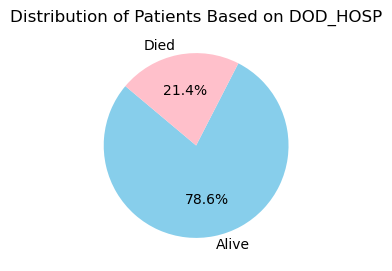

In [ ]:
# Create a new column 'DEATH_HOSP' to classify patients died in hospital
patients['DEATH_HOSP'] = patients['DOD_HOSP'].apply(lambda x: 'Died' if pd.notna(x) else 'Alive')

# Get the counts of each category
death_counts = patients['DEATH_HOSP'].value_counts()

# Plot
plt.figure(figsize=(5,3))
plt.pie(death_counts, labels=death_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'pink'])
plt.title('Distribution of Patients Based on DOD_HOSP')
plt.show()

show distribution of gender

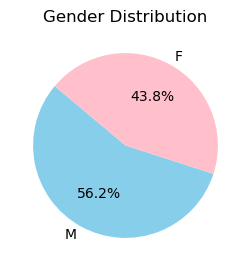

In [ ]:
# Count occurrences of each gender
gender_counts = patients['GENDER'].value_counts()

# Plot pie chart
plt.figure(figsize=(5, 3))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'pink'])
plt.title('Gender Distribution')
plt.show()

### admission_merged

Merge patient data with admission data

In [ ]:
# Merge patients with admission using a left merge
admission_merged = pd.merge(admissions, patients, on='SUBJECT_ID', how='left')
admission_merged

ROW_ID_x  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0            21          22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00   
1            22          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
2            23          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   
3            24          24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00   
4            25          25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00   
...         ...         ...      ...                 ...                 ...   
58971     58594       98800   191113 2131-03-30 21:13:00 2131-04-02 15:02:00   
58972     58595       98802   101071 2151-03-05 20:00:00 2151-03-06 09:10:00   
58973     58596       98805   122631 2200-09-12 07:15:00 2200-09-20 12:08:00   
58974     58597       98813   170407 2128-11-11 02:29:00 2128-12-22 13:11:00   
58975     58598       98813   190264 2131-10-25 03:09:00 2131-10-26 17:44:00   

                 DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0                      NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1                      NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2                      NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                      NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4                      NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
...                    ...            ...                        ...   
58971                  NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   
58972  2151-03-06 09:10:00      EMERGENCY  CLINIC REFERRAL/PREMATURE   
58973                  NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
58974                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
58975                  NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   

              DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0      DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1               HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2               HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                           HOME   Private      NaN  PROTESTANT QUAKER   
4                           HOME   Private      NaN       UNOBTAINABLE   
...                          ...       ...      ...                ...   
58971                       HOME   Private     ENGL      NOT SPECIFIED   
58972               DEAD/EXPIRED  Medicare     ENGL           CATHOLIC   
58973           HOME HEALTH CARE   Private     ENGL      NOT SPECIFIED   
58974                        SNF   Private     ENGL           CATHOLIC   
58975                       HOME   Private     ENGL           CATHOLIC   

      MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0            MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1            MARRIED     WHITE                  NaN                  NaN   
2            MARRIED     WHITE                  NaN                  NaN   
3             SINGLE     WHITE                  NaN                  NaN   
4            MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   
...              ...       ...                  ...                  ...   
58971         SINGLE     WHITE  2131-03-30 19:44:00  2131-03-30 22:41:00   
58972        WIDOWED     WHITE  2151-03-05 17:23:00  2151-03-05 21:06:00   
58973        MARRIED     WHITE                  NaN                  NaN   
58974        MARRIED     WHITE  2128-11-10 23:48:00  2128-11-11 03:16:00   
58975        MARRIED     WHITE  2131-10-25 00:08:00  2131-10-25 04:35:00   

                                               DIAGNOSIS  \
0                                BENZODIAZEPINE OVERDOSE   
1      CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...   
2                                             BRAIN MASS   
3                         INTERIOR MYOCARDIAL INFARCTION   
4                                ACUTE CORONARY SYNDROME   
...                

In [ ]:
duplicated_count = admission_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


**Calculate the age** of each patient using the 'DOB' column. However, it's essential to be aware that dates in MIMIC-III have been shifted to protect patient privacy. Therefore, we're calculating a pseudonymized age rather than the actual age.

In [ ]:
# Convert ADMITTIME and DOB to datetime format
admission_merged['ADMITTIME'] = pd.to_datetime(admission_merged['ADMITTIME'])
admission_merged['DOB'] = pd.to_datetime(admission_merged['DOB'])


def calculate_age(admit_time, dob):
    try:
        # Convert pandas timestamps to Python datetime objects
        admit_datetime = admit_time.to_pydatetime()
        dob_datetime = dob.to_pydatetime()

        # Calculate age
        age = int((admit_datetime - dob_datetime).days // 365.25)
        return age if age > 0 else np.nan  # Assign NaN for negative ages
    except OverflowError:
        return np.nan

# Use the 'apply' method with the function
admission_merged['AGE_AT_ADMISSION'] = admission_merged.apply(lambda row: calculate_age(row['ADMITTIME'], row['DOB']), axis=1)
admission_merged.head()

ROW_ID_x  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0        21          22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00   
1        22          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
2        23          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   
3        24          24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00   
4        25          25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA DEATH_STATUS admission_duration  ROW_ID_y GENDER  \
0                     1        Alive    1 days 03:28:00        19      F   
1                     1        Alive    5 days 11:55:00        20      M   
2                     1        Alive    6 days 18:26:00        20      M   
3                     1        Alive    2 days 20:34:00        21      M   
4                     1        Alive    3 days 12:49:00        22      M   

         DOB  DOD DOD_HOSP DOD_SSN  EXPIRE_FLAG DEATH_HOSP  AGE_AT_ADMISSION  
0 2131-05-07  NaN      NaN     NaN            0      Alive              64.0  
1 2082-07-17  NaN      NaN     NaN            0      Alive              71.0  
2 2082-07-17  NaN      NaN     NaN            0      Alive              75.0  
3 2100-05-31  NaN      NaN     NaN            0      Alive              39.0  
4 2101-11-21  NaN      NaN     NaN            0      Alive              58.0

In [ ]:
nan_count = admission_merged['DOB'].isna().sum()
print(f"The number of NaN values in the 'DOB' column is: {nan_count}")

The number of NaN values in the 'DOB' column is: 0


In [ ]:
nan_count = admission_merged['ADMITTIME'].isna().sum()
print(f"The number of NaN values in the 'ADMITTIME' column is: {nan_count}")

The number of NaN values in the 'ADMITTIME' column is: 0


In [ ]:
nan_count = admission_merged['AGE_AT_ADMISSION'].isna().sum()
print(f"The number of NaN values in the 'AGE_AT_ADMISSION' column is: {nan_count}")

The number of NaN values in the 'AGE_AT_ADMISSION' column is: 8110


In [ ]:
print(round(nan_count/58976*100), '% admissions have negative ages or encountered OverflowError when calculating age')

14 % admissions have negative ages or encountered OverflowError when calculating age


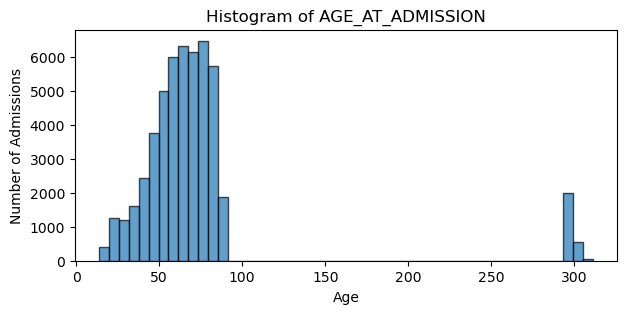

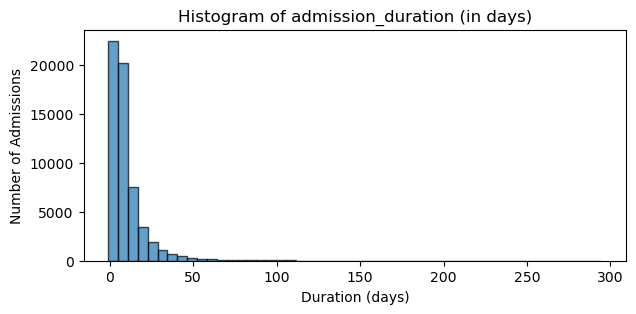

In [ ]:
# Plotting histogram for 'AGE_AT_ADMISSION'
plt.figure(figsize=(7, 3))
plt.hist(admission_merged['AGE_AT_ADMISSION'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of AGE_AT_ADMISSION')
plt.xlabel('Age')
plt.ylabel('Number of Admissions')
plt.show()

# Plotting histogram for 'admission_duration'
# Convert the 'admission_duration' column to days
admission_duration_days = admission_merged['admission_duration'].dt.total_seconds() / (24 * 3600)

plt.figure(figsize=(7, 3))
plt.hist(admission_duration_days, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of admission_duration (in days)')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Admissions')
plt.show()


There are some outliers in 'AGE_AT_ADMISSION', with some patients being ~300 years old.

In [ ]:
age_stats = admission_merged['AGE_AT_ADMISSION'].describe()
print("Statistics for AGE_AT_ADMISSION:")
print(age_stats)

Statistics for AGE_AT_ADMISSION:
count    50866.000000
mean        74.182008
std         54.934994
min         14.000000
25%         52.000000
50%         65.000000
75%         77.000000
max        311.000000
Name: AGE_AT_ADMISSION, dtype: float64


median age = 65

max age = 311?

In [ ]:
implausible_ages = admission_merged[admission_merged['AGE_AT_ADMISSION'] > 130]
implausible_ages

ROW_ID_x  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
8            29          30   104557 2172-10-14 14:17:00 2172-10-19 14:37:00   
12           33          34   115799 2186-07-18 16:46:00 2186-07-20 16:00:00   
13           34          34   144319 2191-02-23 05:23:00 2191-02-25 20:20:00   
39          473         368   105889 2137-07-11 17:56:00 2137-07-16 16:00:00   
40          474         368   138061 2139-12-16 19:48:00 2139-12-22 16:15:00   
...         ...         ...      ...                 ...                 ...   
58911     57504       95420   137041 2141-07-27 09:30:00 2141-08-02 17:53:00   
58920     58543       98647   167391 2156-02-28 17:21:00 2156-03-09 14:49:00   
58939     58562       98713   105148 2140-04-04 13:11:00 2140-04-07 17:00:00   
58940     58563       98714   171885 2104-11-12 12:31:00 2104-11-15 14:40:00   
58942     58565       98720   131917 2178-09-17 18:31:00 2178-09-23 17:30:00   

      DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
8           NaN         URGENT  TRANSFER FROM HOSP/EXTRAM   
12          NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
13          NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   
39          NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
40          NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
...         ...            ...                        ...   
58911       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
58920       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
58939       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58940       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
58942       NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE   

             DISCHARGE_LOCATION INSURANCE LANGUAGE       RELIGION  \
8              HOME HEALTH CARE  Medicare      NaN       CATHOLIC   
12                         HOME  Medicare     ENGL       CATHOLIC   
13             HOME HEALTH CARE  Medicare     ENGL       CATHOLIC   
39                          SNF  Medicare      NaN  NOT SPECIFIED   
40                          SNF  Medicare      NaN  NOT SPECIFIED   
...                         ...       ...      ...            ...   
58911  REHAB/DISTINCT PART HOSP  Medicare     ENGL       CATHOLIC   
58920  REHAB/DISTINCT PART HOSP  Medicare     RUSS         JEWISH   
58939                      HOME  Medicare     ENGL       CATHOLIC   
58940          HOME HEALTH CARE  Medicare     ENGL         JEWISH   
58942   LONG TERM CARE HOSPITAL  Medicare     ENGL         JEWISH   

          MARITAL_STATUS              ETHNICITY            EDREGTIME  \
8                MARRIED  UNKNOWN/NOT SPECIFIED                  NaN   
12               MARRIED                  WHITE                  NaN   
13               MARRIED                  WHITE  2191-02-23 04:23:00   
39               WIDOWED                  WHITE  2137-07-11 15:00:00   
40               WIDOWED                  WHITE  2139-12-15 21:10:00   
...                  ...                    ...                  ...   
58911            WIDOWED                  WHITE                  NaN   
58920             SINGLE                  WHITE  2156-02-28 11:28:00   
58939            WIDOWED                  WHITE                  NaN   
58940  UNKNOWN (DEFAULT)                  WHITE                  NaN   
58942            WIDOWED                  WHITE  2178-09-17 15:54:00   

                 EDOUTTIME                                          DIAGNOSIS  \
8                      NaN                               UNSTABLE ANGINA\CATH   
12                     NaN                                    CHEST PAIN\CATH   
13     2191-02-23 07:25:00                                        BRADYCARDIA   
39     2137-07-11 19:50:00                                          PNEUMONIA   
40     2139-12-16 22:05:00                                          PNEUMONIA   
...                    ...                                                ...   
58911                  NaN  AORTIC STENOSIS\RE-DO ST

There are 2616 admissions with implausible ages of > 130.

In [ ]:
print('percentage of implausible ages:', round(2616/58976*100), '%')

percentage of implausible ages: 4 %


Replace implausible age values (>130) with the median age

In [ ]:
# Compute the median age
median_age = admission_merged['AGE_AT_ADMISSION'].median()

# Replace values greater than 100 with the median age
admission_merged.loc[admission_merged['AGE_AT_ADMISSION'] > 130, 'AGE_AT_ADMISSION'] = median_age

In [ ]:
updated_age_stats = admission_merged['AGE_AT_ADMISSION'].describe()
print("Updated Statistics for AGE_AT_ADMISSION:")
print(updated_age_stats)

Updated Statistics for AGE_AT_ADMISSION:
count    50866.000000
mean        62.113278
std         16.171175
min         14.000000
25%         52.000000
50%         65.000000
75%         75.000000
max         88.000000
Name: AGE_AT_ADMISSION, dtype: float64


In [ ]:
duration_stats = admission_duration_days.describe()
print("Statistics for admission_duration:")
print(duration_stats)

Statistics for admission_duration:
count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: admission_duration, dtype: float64


- The minimum value being negative doesn't make sense for a duration.
- The large standard deviation relative to the mean suggests a wide spread in the data.
- The max value seems very high, although it might be plausible depending on the context.

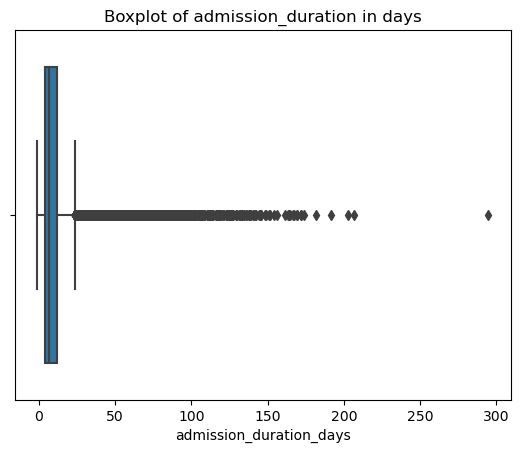

In [ ]:
# Convert timedelta to days
admission_merged['admission_duration_days'] = admission_merged['admission_duration'].dt.total_seconds() / (24 * 3600)

# Plot the boxplot
sns.boxplot(x=admission_merged['admission_duration_days'])
plt.title('Boxplot of admission_duration in days')
plt.show()

In [ ]:
count_over_200_days = (admission_merged['admission_duration_days'] > 200).sum()
print(count_over_200_days)

3


In [ ]:
count_negative_days = (admission_merged['admission_duration_days'] < 0).sum()
print(count_negative_days)

98


### 3. DIAGNOSES_ICD.csv

DIAGNOSES_ICD: recorded 6 weeks after patient discharged.

In [ ]:
diagnoses_icd

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0         1297         109   172335      1.0     40301
1         1298         109   172335      2.0       486
2         1299         109   172335      3.0     58281
3         1300         109   172335      4.0      5855
4         1301         109   172335      5.0      4254
...        ...         ...      ...      ...       ...
651042  639798       97503   188195      2.0     20280
651043  639799       97503   188195      3.0     V5869
651044  639800       97503   188195      4.0     V1279
651045  639801       97503   188195      5.0      5275
651046  639802       97503   188195      6.0      5569

[651047 rows x 5 columns]

In [ ]:
diagnoses_icd['ICD9_CODE'].isnull().sum()

47

47 admitted patients do not have ICD9_CODE

### 4. D_ICD_DIAGNOSES.csv

In [ ]:
d_icd_diagnoses

ROW_ID ICD9_CODE               SHORT_TITLE  \
0         174     01166     TB pneumonia-oth test   
1         175     01170    TB pneumothorax-unspec   
2         176     01171   TB pneumothorax-no exam   
3         177     01172  TB pneumothorx-exam unkn   
4         178     01173  TB pneumothorax-micro dx   
...       ...       ...                       ...   
14562   14432     V7399     Scrn unspcf viral dis   
14563   14433      V740     Screening for cholera   
14564   14434      V741    Screening-pulmonary TB   
14565   14435      V742     Screening for leprosy   
14566   14436      V743  Screening for diphtheria   

                                              LONG_TITLE  
0      Tuberculous pneumonia [any form], tubercle bac...  
1                  Tuberculous pneumothorax, unspecified  
2      Tuberculous pneumothorax, bacteriological or h...  
3      Tuberculous pneumothorax, bacteriological or h...  
4      Tuberculous pneumothorax, tubercle bacilli fou...  
...                                                  ...  
14562  Special screening examination for unspecified ...  
14563                  Screening examination for cholera  
14564   Screening examination for pulmonary tuberculosis  
14565  Screening examination for leprosy (Hansen's di...  
14566               Screening examination for diphtheria  

[14567 rows x 4 columns]

### diagnosis_merged
Merge diagnosis ICD9_CODE to their respective names

In [ ]:
# Convert the ICD9_CODE columns in all DataFrames to string data type
d_icd_diagnoses['ICD9_CODE'] = d_icd_diagnoses['ICD9_CODE'].astype(str)
diagnoses_icd['ICD9_CODE'] = diagnoses_icd['ICD9_CODE'].astype(str)

# Merge diagnosis with diagnosis_icd using a left merge
diagnosis_merged = pd.merge(diagnoses_icd, d_icd_diagnoses, on='ICD9_CODE', how='left')
diagnosis_merged

ROW_ID_x  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  ROW_ID_y  \
0           1297         109   172335      1.0     40301    4312.0   
1           1298         109   172335      2.0       486    5528.0   
2           1299         109   172335      3.0     58281    5892.0   
3           1300         109   172335      4.0      5855    5913.0   
4           1301         109   172335      5.0      4254    4435.0   
...          ...         ...      ...      ...       ...       ...   
651042    639798       97503   188195      2.0     20280    1859.0   
651043    639799       97503   188195      3.0     V5869   12800.0   
651044    639800       97503   188195      4.0     V1279   13957.0   
651045    639801       97503   188195      5.0      5275    5971.0   
651046    639802       97503   188195      6.0      5569    5573.0   

                     SHORT_TITLE  \
0         Mal hyp kid w cr kid V   
1        Pneumonia, organism NOS   
2       Chr nephritis in oth dis   
3       Chron kidney dis stage V   
4        Prim cardiomyopathy NEC   
...                          ...   
651042  Oth lymp unsp xtrndl org   
651043    Long-term use meds NEC   
651044  Prsnl hst ot spf dgst ds   
651045            Sialolithiasis   
651046  Ulceratve colitis unspcf   

                                               LONG_TITLE  
0       Hypertensive chronic kidney disease, malignant...  
1                         Pneumonia, organism unspecified  
2       Chronic glomerulonephritis in diseases classif...  
3                         Chronic kidney disease, Stage V  
4                          Other primary cardiomyopathies  
...                                                   ...  
651042  Other malignant lymphomas, unspecified site, e...  
651043       Long-term (current) use of other medications  
651044  Personal history of other diseases of digestiv...  
651045                                     Sialolithiasis  
651046                    Ulcerative colitis, unspecified  

[651047 rows x 8 columns]

Since a patient can have multiple ICD-9 codes during a single admission (i.e., they can have multiple diagnoses), the SEQ_NUM helps in denoting the order or priority of those diagnoses. A SEQ_NUM of 1 denotes the primary diagnosis, which is often the main reason for the hospital admission.

In [ ]:
duplicated_count = diagnosis_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


**Most Common ICD-9 Codes**

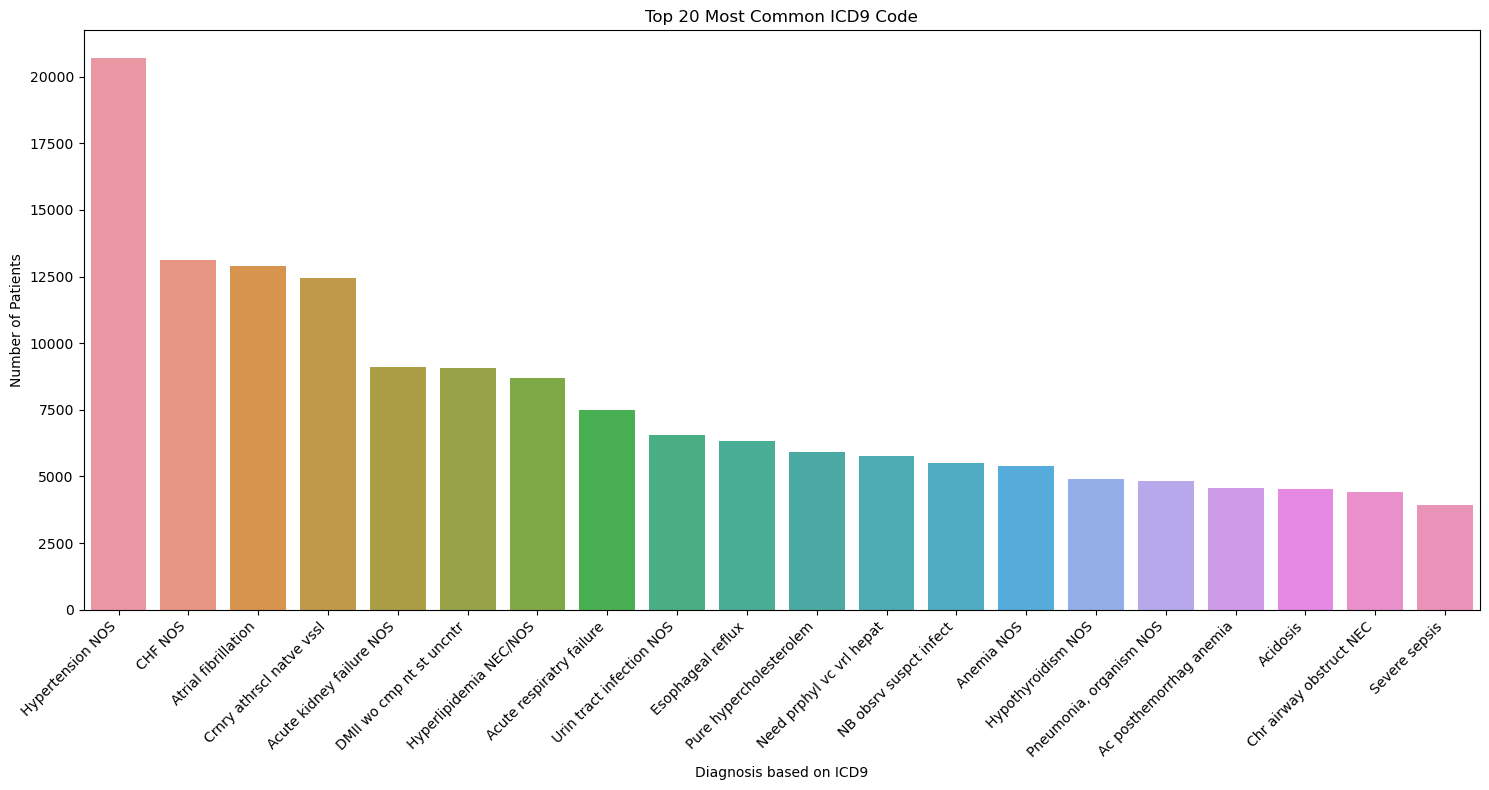

In [ ]:
# Count the occurrences of each icd
icd_counts = diagnosis_merged['SHORT_TITLE'].value_counts()

# Take the top 20 most common icd
top_icd = icd_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_icd.index, y=top_icd.values)
plt.title('Top 20 Most Common ICD9 Code')
plt.xlabel('Diagnosis based on ICD9')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the diagnosis names for better readability
plt.tight_layout()
plt.show()

The bar chart above shows the top 20 most common ICD9 code.

Filter the diagnosis_merged table for the specific HADM_ID of 188195 and then retrieve the ICD9_CODE and SHORT_TITLE values associated with it

In [ ]:
# Filter for HADM_ID 188195
diagnosis188195 = diagnosis_merged[diagnosis_merged['HADM_ID'] == 188195][['ICD9_CODE', 'SHORT_TITLE']]

# Display the filtered data
print(diagnosis188195)


       ICD9_CODE               SHORT_TITLE
646694     28529  Anemia-other chronic dis
646695     07032  Hpt B chrn wo cm wo dlta
651041      7842   Swelling in head & neck
651042     20280  Oth lymp unsp xtrndl org
651043     V5869    Long-term use meds NEC
651044     V1279  Prsnl hst ot spf dgst ds
651045      5275            Sialolithiasis
651046      5569  Ulceratve colitis unspcf


This shows that one patient can have multiple diagnosis.

### 5. PROCEDURES_ICD.csv

In [ ]:
procedures_icd

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0          944       62641   154460        3      3404
1          945        2592   130856        1      9671
2          946        2592   130856        2      3893
3          947       55357   119355        1      9672
4          948       55357   119355        2       331
...        ...         ...      ...      ...       ...
240090  228330       67415   150871        5      3736
240091  228331       67415   150871        6      3893
240092  228332       67415   150871        7      8872
240093  228333       67415   150871        8      3893
240094  228334       67415   150871        9      3722

[240095 rows x 5 columns]

### 6. D_ICD_PROCEDURES.csv

In [ ]:
d_icd_procedures

ROW_ID  ICD9_CODE               SHORT_TITLE  \
0        264        851                Canthotomy   
1        265        852           Blepharorrhaphy   
2        266        859   Adjust lid position NEC   
3        267        861  Lid reconst w skin graft   
4        268        862   Lid reconst w muc graft   
...      ...        ...                       ...   
3877    3344       9959  Vaccination/innocula NEC   
3878    3345       9960  Cardiopulm resuscita NOS   
3879    3346       9961      Atrial cardioversion   
3880    3347       9962    Heart countershock NEC   
3881    3348       9963  Closed chest card massag   

                                             LONG_TITLE  
0                                            Canthotomy  
1                                       Blepharorrhaphy  
2                      Other adjustment of lid position  
3      Reconstruction of eyelid with skin flap or graft  
4     Reconstruction of eyelid with mucous membrane ...  
...                                                 ...  
3877                  Other vaccination and inoculation  
3878  Cardiopulmonary resuscitation, not otherwise s...  
3879                               Atrial cardioversion  
3880               Other electric countershock of heart  
3881                       Closed chest cardiac massage  

[3882 rows x 4 columns]

Check for duplicates in the procedure_icd table.

In [ ]:
# Count occurrences of each ICD9_CODE in procedure_icd
icd_counts = d_icd_procedures['ICD9_CODE'].value_counts()

# Filter out ICD9_CODE values that occur only once (i.e., retain only duplicates)
duplicates = icd_counts[icd_counts > 1]

print(duplicates)

101    2
613    2
714    2
713    2
700    2
      ..
111    2
863    2
110    2
96     2
412    2
Name: ICD9_CODE, Length: 73, dtype: int64


In [ ]:
# Find duplicated ICD9_CODE values in procedure_icd
duplicated_icd_codes = d_icd_procedures[d_icd_procedures['ICD9_CODE'].duplicated(keep=False)]

# Sort them by ICD9_CODE for easier inspection
duplicated_icd_codes_sorted = duplicated_icd_codes.sort_values(by='ICD9_CODE')

# Display the sorted duplicated rows
print(duplicated_icd_codes_sorted)


      ROW_ID  ICD9_CODE               SHORT_TITLE  \
449      261         16       Excise skull lesion   
335      147         16   Pressurized treat graft   
437      249         31  Intraspin nerve root div   
346      158         31              CAS w CT/CTA   
378      190         34  Excis spinal cord lesion   
...      ...        ...                       ...   
2063    2063        843    Amputation stump revis   
5        269        863  Lid reconst w hair graft   
3399    3479        863  Other local destruc skin   
6        270        864  Lid recon-tarsoconj flap   
3400    3480        864    Radical excis skin les   

                                             LONG_TITLE  
449                         Excision of lesion of skull  
335   Pressurized treatment of venous bypass graft [...  
437                  Division of intraspinal nerve root  
346               Computer assisted surgery with CT/CTA  
378   Excision or destruction of lesion of spinal co...  
...            

Combine data from duplicated rows. Concatenate the descriptions for the same ICD code


In [ ]:
# combine the descriptions for the same ICD code
d_icd_procedures['SHORT_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['SHORT_TITLE'].transform(lambda x: ' | '.join(x))
d_icd_procedures['LONG_TITLE'] = d_icd_procedures.groupby('ICD9_CODE')['LONG_TITLE'].transform(lambda x: ' | '.join(x))

procedure_icd_cleaned = d_icd_procedures.drop_duplicates(subset='ICD9_CODE', keep='first')
procedure_icd_cleaned

ROW_ID  ICD9_CODE               SHORT_TITLE  \
0        264        851                Canthotomy   
1        265        852           Blepharorrhaphy   
2        266        859   Adjust lid position NEC   
3        267        861  Lid reconst w skin graft   
4        268        862   Lid reconst w muc graft   
...      ...        ...                       ...   
3877    3344       9959  Vaccination/innocula NEC   
3878    3345       9960  Cardiopulm resuscita NOS   
3879    3346       9961      Atrial cardioversion   
3880    3347       9962    Heart countershock NEC   
3881    3348       9963  Closed chest card massag   

                                             LONG_TITLE  
0                                            Canthotomy  
1                                       Blepharorrhaphy  
2                      Other adjustment of lid position  
3      Reconstruction of eyelid with skin flap or graft  
4     Reconstruction of eyelid with mucous membrane ...  
...                                                 ...  
3877                  Other vaccination and inoculation  
3878  Cardiopulmonary resuscitation, not otherwise s...  
3879                               Atrial cardioversion  
3880               Other electric countershock of heart  
3881                       Closed chest cardiac massage  

[3809 rows x 4 columns]

### procedure_merged
Merge patient's (HADM_ID) procedure ICD9_CODE to their respective names

In [ ]:
# Convert the ICD9_CODE columns in all DataFrames to string data type
procedure_icd_cleaned = procedure_icd_cleaned.copy()
procedure_icd_cleaned['ICD9_CODE'] = procedure_icd_cleaned['ICD9_CODE'].astype(str)
procedures_icd['ICD9_CODE'] = procedures_icd['ICD9_CODE'].astype(str)

# Merge procedure with procedure_icd using a left merge
procedure_merged = pd.merge(procedures_icd, procedure_icd_cleaned, on='ICD9_CODE', how='left')
procedure_merged

ROW_ID_x  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  ROW_ID_y  \
0            944       62641   154460        3      3404     496.0   
1            945        2592   130856        1      9671    3678.0   
2            946        2592   130856        2      3893     801.0   
3            947       55357   119355        1      9672    3679.0   
4            948       55357   119355        2       331     187.0   
...          ...         ...      ...      ...       ...       ...   
240090    228330       67415   150871        5      3736    1300.0   
240091    228331       67415   150871        6      3893     801.0   
240092    228332       67415   150871        7      8872    3233.0   
240093    228333       67415   150871        8      3893     801.0   
240094    228334       67415   150871        9      3722     805.0   

                          SHORT_TITLE  \
0             Insert intercostal cath   
1            Cont inv mec ven <96 hrs   
2                     Venous cath NEC   
3            Cont inv mec ven 96+ hrs   
4       Spinal tap | Incision of lung   
...                               ...   
240090         Exc,destrct,exclus LAA   
240091                Venous cath NEC   
240092            Dx ultrasound-heart   
240093                Venous cath NEC   
240094        Left heart cardiac cath   

                                               LONG_TITLE  
0          Insertion of intercostal catheter for drainage  
1       Continuous invasive mechanical ventilation for...  
2        Venous catheterization, not elsewhere classified  
3       Continuous invasive mechanical ventilation for...  
4                           Spinal tap | Incision of lung  
...                                                   ...  
240090  Excision, destruction, or exclusion of left at...  
240091   Venous catheterization, not elsewhere classified  
240092                     Diagnostic ultrasound of heart  
240093   Venous catheterization, not elsewhere classified  
240094                 Left heart cardiac catheterization  

[240095 rows x 8 columns]

In [ ]:
duplicated_count = procedure_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


Show top 20 procedures being performed in the hospital

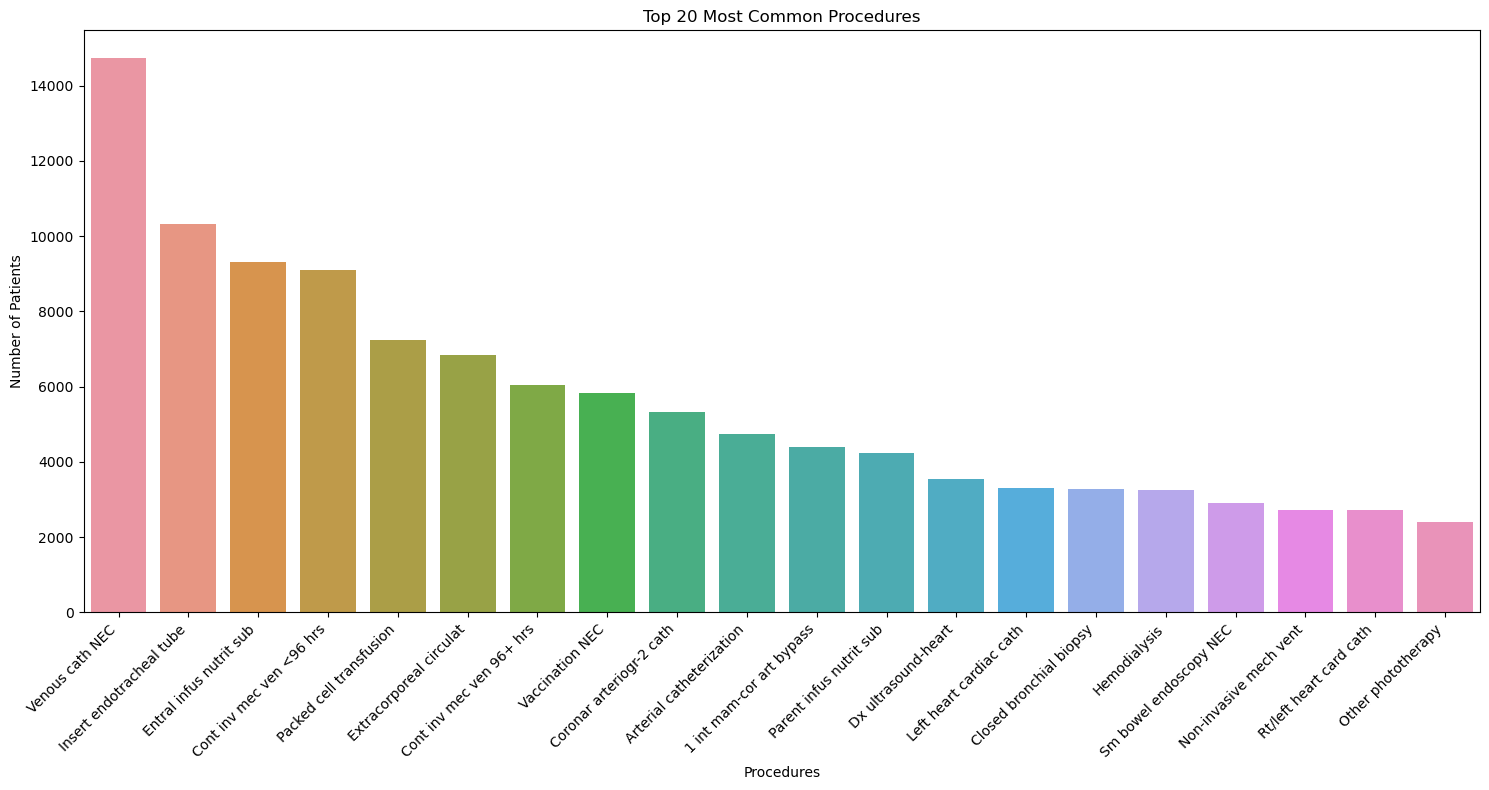

In [ ]:
# Count the occurrences of each icd
procedure_counts = procedure_merged['SHORT_TITLE'].value_counts()

# Take the top 20 most common icd
top_precedure = procedure_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_precedure.index, y=top_precedure.values)
plt.title('Top 20 Most Common Procedures')
plt.xlabel('Procedures')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the procedures names for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Filter for HADM_ID 150871
procedures150871 = procedure_merged[procedure_merged['HADM_ID'] == 150871][['ICD9_CODE', 'SHORT_TITLE']]

# Display the filtered data
print(procedures150871)

       ICD9_CODE               SHORT_TITLE
232505      8856  Coronar arteriogr-2 cath
240086      3523  Opn/oth rep mtrl vlv-tis
240087      3733  Exc/dest hrt lesion open
240088      3961   Extracorporeal circulat
240089      3727           Cardiac mapping
240090      3736    Exc,destrct,exclus LAA
240091      3893           Venous cath NEC
240092      8872       Dx ultrasound-heart
240093      3893           Venous cath NEC
240094      3722   Left heart cardiac cath


This shows one admission can also have multiple procedures

### 7. PROCEDUREEVENTS_MV.csv

In [ ]:
procedureevents_mv

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID            STARTTIME  \
0          379       29070   115071    232563.0  2145-03-12 23:04:00   
1          380       29070   115071    232563.0  2145-03-12 23:04:00   
2          381       29070   115071    232563.0  2145-03-12 23:05:00   
3          382       29070   115071    232563.0  2145-03-12 23:36:00   
4          383       29070   115071    232563.0  2145-03-13 01:27:00   
...        ...         ...      ...         ...                  ...   
258061  257337       41958   182711    246007.0  2155-08-09 01:51:00   
258062  257338       41958   182711    246007.0  2155-08-09 01:57:00   
258063  257339       41958   182711    246007.0  2155-08-09 01:57:00   
258064  257340       41958   182711    246007.0  2155-08-09 01:57:00   
258065  257341       41958   182711    246007.0  2155-08-09 02:20:00   

                    ENDTIME  ITEMID   VALUE VALUEUOM         LOCATION  \
0       2145-03-12 23:05:00  225401     1.0     None              NaN   
1       2145-03-12 23:05:00  225454     1.0     None              NaN   
2       2145-03-18 20:01:00  225792  8456.0     hour              NaN   
3       2145-03-12 23:37:00  225402     1.0     None              NaN   
4       2145-03-16 16:00:00  224560  5193.0      min         Right IJ   
...                     ...     ...     ...      ...              ...   
258061  2155-08-10 11:20:00  225204  2009.0      min  Right Antecube    
258062  2155-08-09 01:58:00  225402     1.0     None              NaN   
258063  2155-08-09 01:58:00  225459     1.0     None              NaN   
258064  2155-08-09 01:58:00  225966     1.0     None              NaN   
258065  2155-08-09 02:21:00  225401     1.0     None              NaN   

       LOCATIONCATEGORY            STORETIME   CGID  ORDERID  LINKORDERID  \
0                   NaN  2145-03-12 23:04:00  20855  5092605      5092605   
1                   NaN  2145-03-12 23:04:00  20855  2538599      2538599   
2                   NaN  2145-03-18 20:01:39  20889  2383835      2383835   
3                   NaN  2145-03-12 23:36:00  20855  9355062      9355062   
4       Invasive Venous  2145-03-16 17:57:00  20855   466169       466169   
...                 ...                  ...    ...      ...          ...   
258061  Invasive Venous  2155-08-10 11:28:00  20622  5298304      5298304   
258062              NaN  2155-08-09 01:57:00  20622  1274140      1274140   
258063              NaN  2155-08-09 01:57:00  20622  9407758      9407758   
258064              NaN  2155-08-09 01:57:00  20622  8200334      8200334   
258065              NaN  2155-08-09 02:20:00  19689  8848376      8848376   

       ORDERCATEGORYNAME  SECONDARYORDERCATEGORYNAME ORDERCATEGORYDESCRIPTION  \
0             Procedures                         NaN             Electrolytes   
1             Procedures                         NaN             Electrolytes   
2            Ventilation                         NaN                     Task   
3             Procedures                         NaN             Electrolytes   
4         Invasive Lines                         NaN                     Task   
...                  ...                         ...                      ...   
258061    Invasive Lines                         NaN                     Task   
258062        Procedures                         NaN             Electrolytes   
258063           Imaging                         NaN             Electrolytes   
258064        Procedures                         NaN             Electrolytes   
258065        Procedures                         NaN             Electrolytes   

        ISOPENBAG  CONTINUEINNEXTDEPT  CANCELREASON STATUSDESCRIPTION  \
0               0                   0             0   FinishedRunning   
1               0                   0             0   FinishedRunning   
2               1                   0             0   FinishedRunning   
3               0                   0             0   FinishedRunning   
4  

### 8. D_LABITEMS.csv

In [ ]:
d_labitems

ROW_ID  ITEMID                       LABEL                      FLUID  \
0       546   51346                      Blasts  Cerebrospinal Fluid (CSF)   
1       547   51347                 Eosinophils  Cerebrospinal Fluid (CSF)   
2       548   51348             Hematocrit, CSF  Cerebrospinal Fluid (CSF)   
3       549   51349  Hypersegmented Neutrophils  Cerebrospinal Fluid (CSF)   
4       550   51350           Immunophenotyping  Cerebrospinal Fluid (CSF)   
..      ...     ...                         ...                        ...   
748     749   51551             VOIDED SPECIMEN           OTHER BODY FLUID   
749     750   51552             VOIDED SPECIMEN                      STOOL   
750     751   51553             VOIDED SPECIMEN                      URINE   
751     752   51554             VOIDED SPECIMEN                JOINT FLUID   
752     753   51555    SURFACTANT ALBUMIN RATIO           OTHER BODY FLUID   

       CATEGORY LOINC_CODE  
0    Hematology    26447-3  
1    Hematology    26451-5  
2    Hematology    30398-2  
3    Hematology    26506-6  
4    Hematology        NaN  
..          ...        ...  
748  HEMATOLOGY        NaN  
749   CHEMISTRY        NaN  
750   CHEMISTRY        NaN  
751  HEMATOLOGY        NaN  
752   CHEMISTRY        NaN  

[753 rows x 6 columns]

### 9. LABEVENTS.csv

In [ ]:
labevents

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID            CHARTTIME VALUE  \
0              281           3       NaN   50820  2101-10-12 16:07:00  7.39   
1              282           3       NaN   50800  2101-10-12 18:17:00   ART   
2              283           3       NaN   50802  2101-10-12 18:17:00    -1   
3              284           3       NaN   50804  2101-10-12 18:17:00    22   
4              285           3       NaN   50808  2101-10-12 18:17:00  0.93   
...            ...         ...       ...     ...                  ...   ...   
27854050  27428435       96443  103219.0   50882  2109-12-30 01:40:00    26   
27854051  27428436       96443  103219.0   50885  2109-12-30 01:40:00   2.1   
27854052  27428437       96443  103219.0   50902  2109-12-30 01:40:00    97   
27854053  27428438       96443  103219.0   50911  2109-12-30 01:40:00     2   
27854054  27428439       96443  103219.0   50912  2109-12-30 01:40:00   1.6   

          VALUENUM VALUEUOM      FLAG  
0             7.39    units       NaN  
1              NaN      NaN       NaN  
2            -1.00    mEq/L       NaN  
3            22.00    mEq/L       NaN  
4             0.93   mmol/L  abnormal  
...            ...      ...       ...  
27854050     26.00    mEq/L       NaN  
27854051      2.10    mg/dL  abnormal  
27854052     97.00    mEq/L       NaN  
27854053      2.00    ng/mL       NaN  
27854054      1.60    mg/dL  abnormal  

[27854055 rows x 9 columns]

### lab_merged
Merge lab items with lab events

In [ ]:
# Merge lab_event with lab_item using a left merge
lab_merged = pd.merge(labevents, d_labitems, on='ITEMID', how='left')
lab_merged

ROW_ID_x  SUBJECT_ID   HADM_ID  ITEMID            CHARTTIME VALUE  \
0              281           3       NaN   50820  2101-10-12 16:07:00  7.39   
1              282           3       NaN   50800  2101-10-12 18:17:00   ART   
2              283           3       NaN   50802  2101-10-12 18:17:00    -1   
3              284           3       NaN   50804  2101-10-12 18:17:00    22   
4              285           3       NaN   50808  2101-10-12 18:17:00  0.93   
...            ...         ...       ...     ...                  ...   ...   
27854050  27428435       96443  103219.0   50882  2109-12-30 01:40:00    26   
27854051  27428436       96443  103219.0   50885  2109-12-30 01:40:00   2.1   
27854052  27428437       96443  103219.0   50902  2109-12-30 01:40:00    97   
27854053  27428438       96443  103219.0   50911  2109-12-30 01:40:00     2   
27854054  27428439       96443  103219.0   50912  2109-12-30 01:40:00   1.6   

          VALUENUM VALUEUOM      FLAG  ROW_ID_y  \
0             7.39    units       NaN        21   
1              NaN      NaN       NaN         1   
2            -1.00    mEq/L       NaN         3   
3            22.00    mEq/L       NaN         5   
4             0.93   mmol/L  abnormal         9   
...            ...      ...       ...       ...   
27854050     26.00    mEq/L       NaN        83   
27854051      2.10    mg/dL  abnormal        86   
27854052     97.00    mEq/L       NaN       103   
27854053      2.00    ng/mL       NaN       112   
27854054      1.60    mg/dL  abnormal       113   

                                  LABEL  FLUID   CATEGORY LOINC_CODE  
0                                    pH  Blood  Blood Gas    11558-4  
1                         SPECIMEN TYPE  BLOOD  BLOOD GAS        NaN  
2                           Base Excess  Blood  Blood Gas    11555-0  
3                  Calculated Total CO2  Blood  Blood Gas    34728-6  
4                          Free Calcium  Blood  Blood Gas     1994-3  
...                                 ...    ...        ...        ...  
27854050                    Bicarbonate  Blood  Chemistry     1963-8  
27854051               Bilirubin, Total  Blood  Chemistry     1975-2  
27854052                       Chloride  Blood  Chemistry     2075-0  
27854053  Creatine Kinase, MB Isoenzyme  Blood  Chemistry     6773-6  
27854054                     Creatinine  Blood  Chemistry     2160-0  

[27854055 rows x 14 columns]

In [ ]:
duplicated_count = lab_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


Show lab category

In [ ]:
# Get the counts for each unique value in CATEGORY
category_counts = lab_merged['CATEGORY'].value_counts()

print(category_counts)

Hematology    11872248
Chemistry     10971567
Blood Gas      4593241
BLOOD GAS       404785
CHEMISTRY        12201
HEMATOLOGY          13
Name: CATEGORY, dtype: int64


There are mainly 3 categories here. **Hematology, Chemistry and Blood Gas** are repeated in uppercase letter.

A blood gas test, often referred to as an arterial blood gas (ABG) test, is a procedure that measures the amounts of oxygen and carbon dioxide in the blood, as well as the balance of acid and base (pH level). It provides information about how well the lungs are able to move oxygen into the blood and remove carbon dioxide from the blood.

In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Blood Gas'
bloodgas_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'blood gas']

# Get unique values in the 'LABEL' column
bloodgas_labels = bloodgas_df['LABEL'].unique()
print(bloodgas_labels)

['pH' 'SPECIMEN TYPE' 'Base Excess' 'Calculated Total CO2' 'Free Calcium'
 'Intubated' 'Lactate' 'pCO2' 'pO2' 'Temperature' 'Oxygen'
 'Oxygen Saturation' 'PEEP' 'Tidal Volume' 'Ventilation Rate' 'Ventilator'
 'Hematocrit, Calculated' 'Hemoglobin' 'Glucose' 'Potassium, Whole Blood'
 'Alveolar-arterial Gradient' 'Required O2' 'Sodium, Whole Blood'
 'Calculated Bicarbonate, Whole Blood' 'Chloride, Whole Blood' 'O2 Flow'
 'Methemoglobin' 'Carboxyhemoglobin' 'Fluid Type' 'pO2, Body Fluid'
 'pCO2, Body Fluid' 'Potassium' 'Sodium, Body Fluid']


In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Hematology'
hematology_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'hematology']

# Get unique values in the 'LABEL' column
hematology_labels = hematology_df['LABEL'].unique()
print(hematology_labels)

['Hematocrit' 'Anisocytosis' 'Basophils' 'Eosinophils' 'Hemoglobin'
 'Hypochromia' 'Lymphocytes' 'Macrocytes' 'MCH' 'MCHC' 'MCV' 'Microcytes'
 'Monocytes' 'Neutrophils' 'Platelet Count' 'Poikilocytosis' 'RDW'
 'Red Blood Cell Fragments' 'Red Blood Cells' 'White Blood Cells'
 'Bilirubin' 'Blood' 'Glucose' 'Ketone' 'Leukocytes' 'Nitrite' 'pH'
 'Protein' 'Specific Gravity' 'Urine Appearance' 'Urine Color'
 'Urobilinogen' 'Bacteria' 'Epithelial Cells' 'Hyaline Casts' 'RBC'
 'Urine Mucous' 'WBC' 'Yeast' 'PTT' 'INR(PT)' 'PT'
 'Fibrinogen, Functional' 'Atypical Lymphocytes' 'Bands' 'Metamyelocytes'
 'Myelocytes' 'Polychromasia' 'Nucleated Red Cells' 'Platelet Smear'
 'Absolute CD3 Count' 'Absolute CD4 Count' 'Absolute CD8 Count'
 'Absolute Lymphocyte Count' 'CD3 Cells, Percent' 'CD4 Cells, Percent'
 'CD4/CD8 Ratio' 'CD8 Cells, Percent' 'Lymphocytes, Percent' 'WBC Count'
 'Transitional Epithelial Cells' 'D-Dimer' 'Fibrin Degradation Products'
 'Reticulocyte Count, Automated' 'Burr Cells' 'WBC 

In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Chemistry'
chemistry_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'chemistry']

# Get unique values in the 'LABEL' column
chemistry_labels = chemistry_df['LABEL'].unique()
print(chemistry_labels)

['Anion Gap' 'Bicarbonate' 'Calcium, Total' 'Chloride' 'Creatinine'
 'Glucose' 'Magnesium' 'Phosphate' 'Potassium' 'Sodium' 'Urea Nitrogen'
 'Vancomycin' 'Alanine Aminotransferase (ALT)'
 'Asparate Aminotransferase (AST)' 'Creatine Kinase (CK)'
 'Creatine Kinase, MB Isoenzyme' 'Troponin I' 'Alkaline Phosphatase'
 'Bilirubin, Total' 'Albumin' 'Amylase' 'Lipase' 'Uric Acid'
 'Bilirubin, Direct' 'Bilirubin, Indirect' 'Cholesterol Ratio (Total/HDL)'
 'Cholesterol, HDL' 'Cholesterol, LDL, Measured' 'Cholesterol, Total'
 'Triglycerides' 'Blue Top Hold' 'Gamma Glutamyltransferase'
 'Lactate Dehydrogenase (LD)' 'Chloride, Urine' 'Creatinine, Urine'
 'Length of Urine Collection' 'Osmolality, Urine' 'Sodium, Urine'
 'Urea Nitrogen, Urine' 'Ferritin' 'Iron' 'Iron Binding Capacity, Total'
 'Transferrin' 'CK-MB Index' 'Osmolality, Measured' 'Red Top Hold'
 'Thyroid Stimulating Hormone' 'Thyroxine (T4)' 'Green Top Hold (plasma)'
 'Cholesterol, LDL, Calculated' 'GR HOLD' '% Hemoglobin A1c' 'EDTA Hold

In [ ]:
# Get the counts for each unique value in CATEGORY
fluid_counts = lab_merged['FLUID'].value_counts()

print(fluid_counts)

Blood                        25341470
Urine                         1964068
BLOOD                          405141
Cerebrospinal Fluid (CSF)       35917
Ascites                         31224
Pleural                         28393
Other Body Fluid                24667
URINE                           11850
Bone Marrow                      5368
Joint Fluid                      5319
Stool                             630
OTHER BODY FLUID                    6
JOINT FLUID                         2
Name: FLUID, dtype: int64


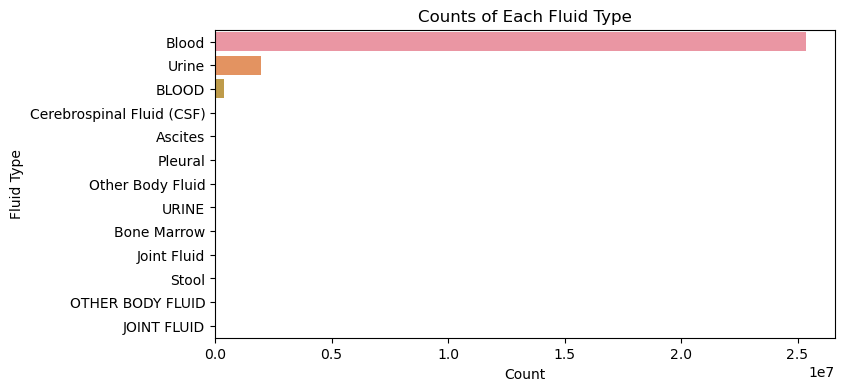

In [ ]:
# Plot fluid counts
plt.figure(figsize=(8, 4))
sns.barplot(y=fluid_counts.index, x=fluid_counts.values)

plt.title('Counts of Each Fluid Type')
plt.xlabel('Count')
plt.ylabel('Fluid Type')
plt.show()

The most common fluid type for lab test is blood.

### 10. MICROBIOLOGYEVENTS.csv

- CHARTDATE: The date the event occurred.
- CHARTTIME: The date and time the event occurred (if available).
- SPEC_ITEMID: Item ID for the specimen type.
- ORG_ITEMID: Item ID for the organism.
- ISOLATE_NUM: Number of organisms isolated from the same sample.
- AB_ITEMID: Item ID for the antibiotic.
- DILUTION_TEXT: Text description of the antibiotic dilution.
- DILUTION_COMPARISON: Comparison used for the antibiotic dilution.
- DILUTION_VALUE: Value of the antibiotic dilution.
- INTERPRETATION: Interpretation of the antibiotic dilution.

In [ ]:
microbiologyevents

ROW_ID  SUBJECT_ID  HADM_ID            CHARTDATE            CHARTTIME  \
0          744          96   170324  2156-04-13 00:00:00  2156-04-13 14:18:00   
1          745          96   170324  2156-04-20 00:00:00  2156-04-20 13:10:00   
2          746          96   170324  2156-04-20 00:00:00  2156-04-20 16:00:00   
3          747          96   170324  2156-04-20 00:00:00                  NaN   
4          748          96   170324  2156-04-20 00:00:00                  NaN   
...        ...         ...      ...                  ...                  ...   
631721  630931       99783   126090  2125-11-05 00:00:00  2125-11-05 13:15:00   
631722  630932       99783   126090  2125-11-06 00:00:00  2125-11-06 10:24:00   
631723  630933       99783   126090  2125-11-06 00:00:00  2125-11-06 10:24:00   
631724  630934       99783   126090  2125-11-07 00:00:00  2125-11-07 12:40:00   
631725  630935       99783   126090  2125-11-07 00:00:00  2125-11-07 14:28:00   

        SPEC_ITEMID          SPEC_TYPE_DESC  ORG_ITEMID  \
0           70021.0  BRONCHOALVEOLAR LAVAGE     80026.0   
1           70062.0                  SPUTUM         NaN   
2           70012.0           BLOOD CULTURE         NaN   
3           70012.0           BLOOD CULTURE         NaN   
4           70079.0                   URINE         NaN   
...             ...                     ...         ...   
631721      70076.0                  TISSUE     80066.0   
631722      70076.0                  TISSUE     80066.0   
631723      70076.0                  TISSUE     80066.0   
631724      70012.0           BLOOD CULTURE         NaN   
631725      70012.0           BLOOD CULTURE         NaN   

                      ORG_NAME  ISOLATE_NUM  AB_ITEMID AB_NAME DILUTION_TEXT  \
0       PSEUDOMONAS AERUGINOSA          1.0        NaN     NaN           NaN   
1                          NaN          NaN        NaN     NaN           NaN   
2                          NaN          NaN        NaN     NaN           NaN   
3                          NaN          NaN        NaN     NaN           NaN   
4                          NaN          NaN        NaN     NaN           NaN   
...                        ...          ...        ...     ...           ...   
631721   ASPERGILLUS FUMIGATUS          2.0        NaN     NaN           NaN   
631722   ASPERGILLUS FUMIGATUS          1.0        NaN     NaN           NaN   
631723   ASPERGILLUS FUMIGATUS          2.0        NaN     NaN           NaN   
631724                     NaN          NaN        NaN     NaN           NaN   
631725                     NaN          NaN        NaN     NaN           NaN   

       DILUTION_COMPARISON  DILUTION_VALUE INTERPRETATION  
0                      NaN             NaN            NaN  
1                      NaN             NaN            NaN  
2                      NaN             NaN            NaN  
3                      NaN             NaN            NaN  
4                      NaN             NaN            NaN  
...                    ...             ...            ...  
631721                 NaN             NaN            NaN  
631722                 NaN             NaN            NaN  
631723                 NaN             NaN            NaN  
631724                 NaN             NaN            NaN  
631725                 NaN             NaN            NaN  

[631726 rows x 16 columns]

In [ ]:
microbiologyevents['ORG_NAME'].nunique()

362

There are 362 unique microorganisms in this dataset. Let's check what's the top 20 most common microorganisms.

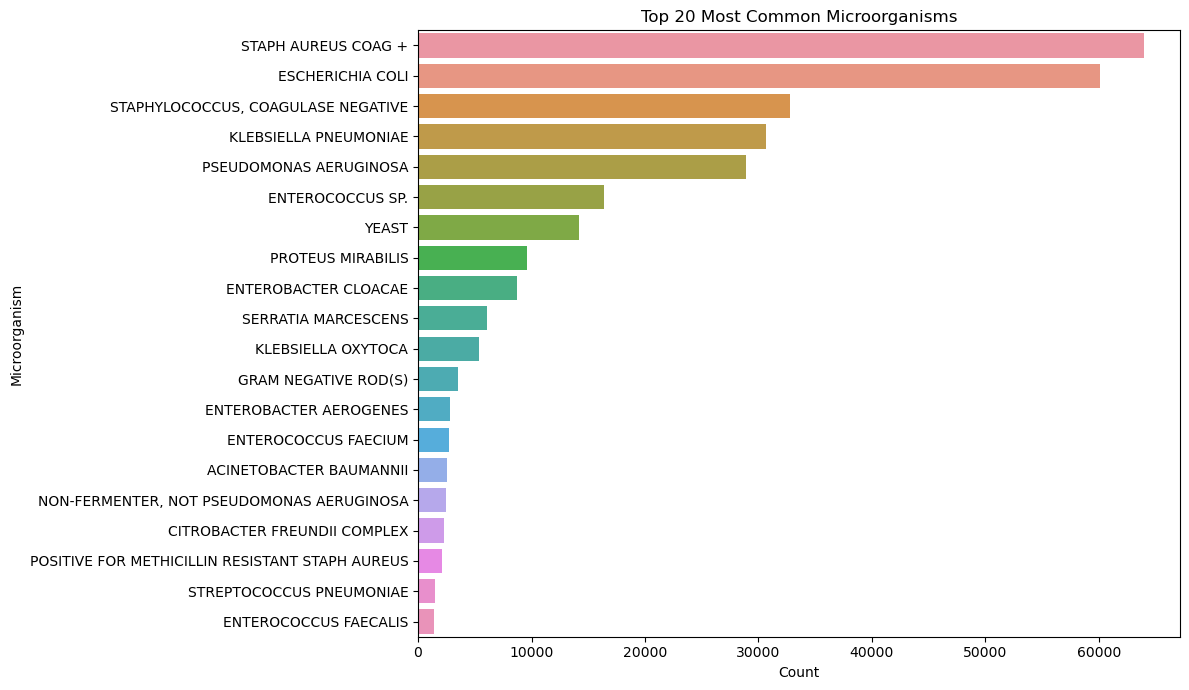

In [ ]:
# Get the top 20 most common microorganisms
top_microorganisms = microbiologyevents['ORG_NAME'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=top_microorganisms.index, x=top_microorganisms.values)
plt.title('Top 20 Most Common Microorganisms')
plt.xlabel('Count')
plt.ylabel('Microorganism')
plt.tight_layout()
plt.show()

The chart above shows the most common microorganisms are Staphylococcus aureus and Escherichia coli.

A network graph where microorganisms and antibiotics are nodes, and edges represent associations (i.e., which antibiotic is tested against which organism).

In [ ]:
#!pip install networkx

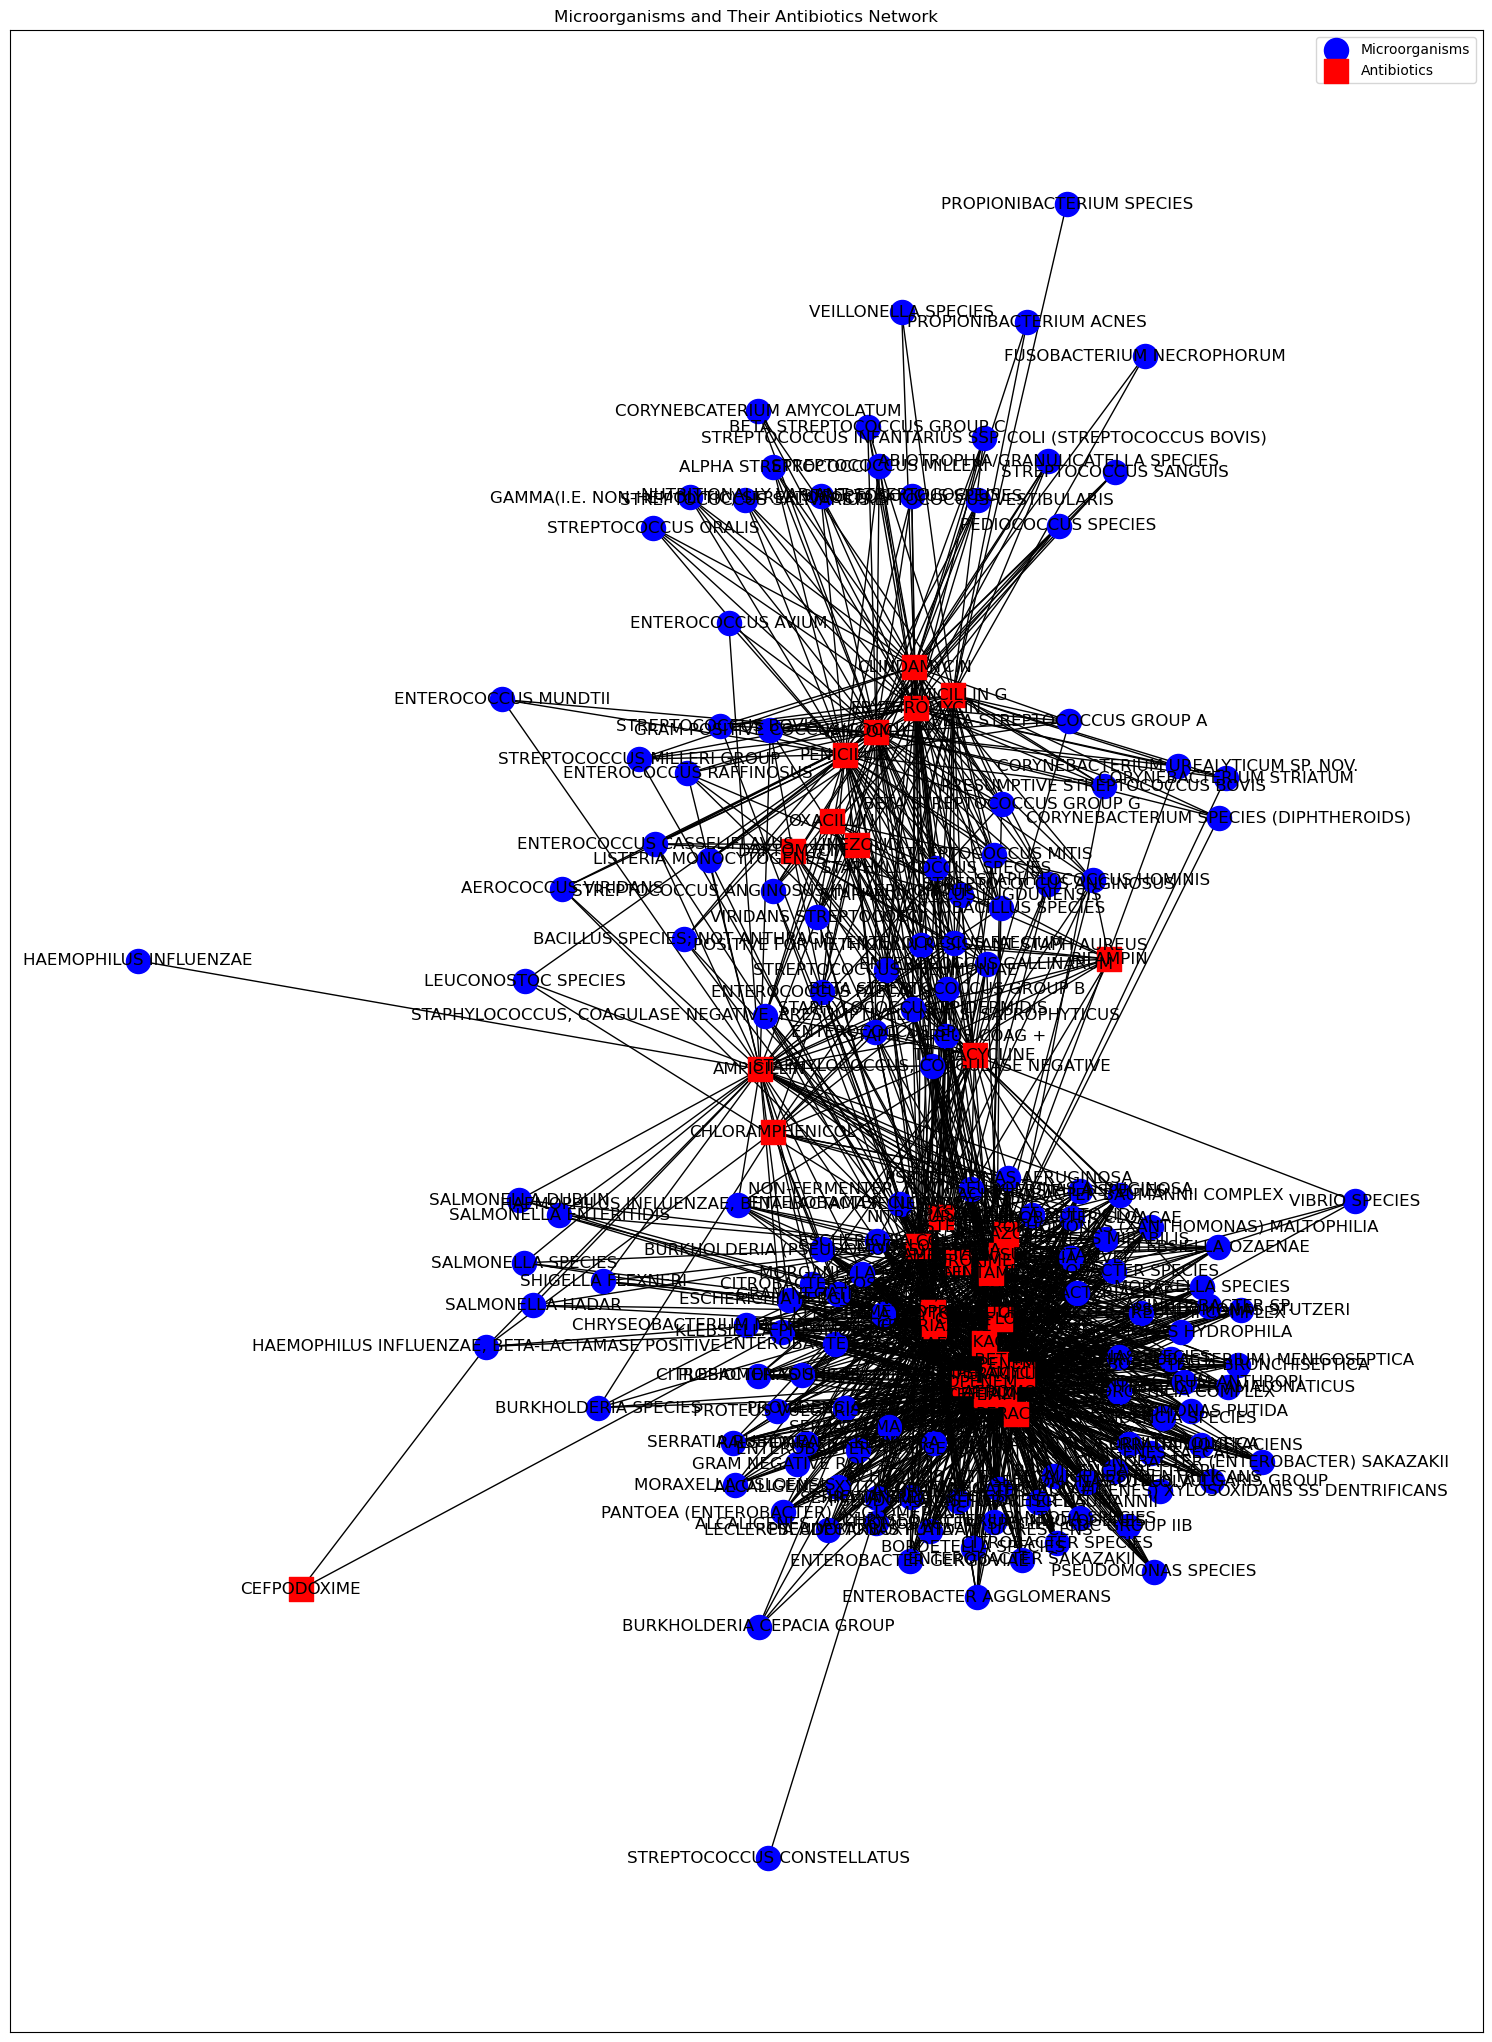

In [ ]:
# Create a new graph
G = nx.Graph()

# Add nodes for each microorganism and antibiotic
for org, ab in microbiologyevents[['ORG_NAME', 'AB_NAME']].dropna().values:
    G.add_node(org, type='organism')
    G.add_node(ab, type='antibiotic')
    G.add_edge(org, ab)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(19, 26))

# Draw organisms
org_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'organism']
nx.draw_networkx_nodes(G, pos, nodelist=org_nodes, node_color='blue', label='Microorganisms')

# Draw antibiotics
ab_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'antibiotic']
nx.draw_networkx_nodes(G, pos, nodelist=ab_nodes, node_color='red', label='Antibiotics', node_shape='s')

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos)

plt.title('Microorganisms and Their Antibiotics Network')
plt.legend()
plt.show()

### 11. ICUSTAYS.csv

In [ ]:
icustays

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID    DBSOURCE FIRST_CAREUNIT  \
0         365         268   110404      280836     carevue           MICU   
1         366         269   106296      206613     carevue           MICU   
2         367         270   188028      220345     carevue            CCU   
3         368         271   173727      249196     carevue           MICU   
4         369         272   164716      210407     carevue            CCU   
...       ...         ...      ...         ...         ...            ...   
61527   59806       94944   143774      201233  metavision           CSRU   
61528   59807       94950   123750      283653  metavision            CCU   
61529   59808       94953   196881      241585  metavision           SICU   
61530   59809       94954   118475      202802  metavision           CSRU   
61531   59810       94956   156386      275346  metavision          TSICU   

      LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0              MICU            52           52  2198-02-14 23:27:38   
1              MICU            52           52  2170-11-05 11:05:29   
2               CCU            57           57  2128-06-24 15:05:20   
3              SICU            52           23  2120-08-07 23:12:42   
4               CCU            57           57  2186-12-25 21:08:04   
...             ...           ...          ...                  ...   
61527          CSRU            15           15  2104-04-15 10:18:16   
61528           CCU             7            7  2155-12-08 05:33:16   
61529          SICU            57           57  2160-03-03 16:09:11   
61530          CSRU            15           15  2183-03-25 09:53:10   
61531         TSICU            14           14  2157-05-19 02:54:54   

                   OUTTIME     LOS  
0      2198-02-18 05:26:11  3.2490  
1      2170-11-08 17:46:57  3.2788  
2      2128-06-27 12:32:29  2.8939  
3      2120-08-10 00:39:04  2.0600  
4      2186-12-27 12:01:13  1.6202  
...                    ...     ...  
61527  2104-04-17 14:51:00  2.1894  
61528  2155-12-10 17:24:58  2.4942  
61529  2160-03-04 14:22:33  0.9259  
61530  2183-03-27 17:55:03  2.3346  
61531  2157-05-23 14:58:04  4.5022  

[61532 rows x 12 columns]

### 12. NOTEEVENTS.csv

care givers (CGID)

In [ ]:
noteevents

ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE            CHARTTIME  \
0            174       22532  167853.0  2151-08-04                  NaN   
1            175       13702  107527.0  2118-06-14                  NaN   
2            176       13702  167118.0  2119-05-25                  NaN   
3            177       13702  196489.0  2124-08-18                  NaN   
4            178       26880  135453.0  2162-03-25                  NaN   
...          ...         ...       ...         ...                  ...   
2083175  2070657       31097  115637.0  2132-01-21  2132-01-21 03:27:00   
2083176  2070658       31097  115637.0  2132-01-21  2132-01-21 09:50:00   
2083177  2070659       31097  115637.0  2132-01-21  2132-01-21 16:42:00   
2083178  2070660       31097  115637.0  2132-01-21  2132-01-21 18:05:00   
2083179  2070661       31097  115637.0  2132-01-21  2132-01-21 18:05:00   

                   STORETIME           CATEGORY DESCRIPTION     CGID  ISERROR  \
0                        NaN  Discharge summary      Report      NaN      NaN   
1                        NaN  Discharge summary      Report      NaN      NaN   
2                        NaN  Discharge summary      Report      NaN      NaN   
3                        NaN  Discharge summary      Report      NaN      NaN   
4                        NaN  Discharge summary      Report      NaN      NaN   
...                      ...                ...         ...      ...      ...   
2083175  2132-01-21 03:38:00      Nursing/other      Report  17581.0      NaN   
2083176  2132-01-21 09:53:00      Nursing/other      Report  19211.0      NaN   
2083177  2132-01-21 16:44:00      Nursing/other      Report  20104.0      NaN   
2083178  2132-01-21 18:16:00      Nursing/other      Report  16023.0      NaN   
2083179  2132-01-21 18:31:00      Nursing/other      Report  16023.0      NaN   

                                                      TEXT  
0        Admission Date:  [**2151-7-16**]       Dischar...  
1        Admission Date:  [**2118-6-2**]       Discharg...  
2        Admission Date:  [**2119-5-4**]              D...  
3        Admission Date:  [**2124-7-21**]              ...  
4        Admission Date:  [**2162-3-3**]              D...  
...                                                    ...  
2083175  NPN\n\n\n#1  Infant remains in RA with O2 sats...  
2083176  Neonatology\nDOL #5, CGA 36 weeks.\n\nCVR: Con...  
2083177  Family Meeting Note\nFamily meeting held with ...  
2083178  NPN 1800\n\n\n#1 Resp: [**Known lastname 2243*...  
2083179  NPN 1800\nNursing Addendum:\n[**Known lastname...  

[2083180 rows x 11 columns]

### Other tables

In [ ]:
#d_items

In [ ]:
#callout

In [ ]:
#caregivers

In [ ]:
#cptevents

In [ ]:
#d_cpt

In [ ]:
#datetimeevents

In [ ]:
#drgcodes

In [ ]:
#inputevents_cv

In [ ]:
#inputevents_mv

In [ ]:
#outputevents

In [ ]:
#prescriptions

In [ ]:
#services

In [ ]:
#transfers

### HAC list
obtained from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8717596/

In [ ]:
hac = pd.read_csv('data/hac_list.csv')
hac

Complication                         Diagnosis    Code  \
0         Pressure injury                    Stage III ulcer   L8920   
1         Pressure injury                    Stage III ulcer   L8921   
2         Pressure injury                    Stage III ulcer   L8922   
3         Pressure injury                    Stage III ulcer   L8923   
4         Pressure injury                    Stage III ulcer   L8924   
..                     ...                               ...     ...   
625  Neonatal birth trauma             Neonatal birth trauma   P15.9   
626  Neonatal birth trauma  Hypoxic ischaemic encephalopathy  P91.60   
627  Neonatal birth trauma  Hypoxic ischaemic encephalopathy  P91.61   
628  Neonatal birth trauma  Hypoxic ischaemic encephalopathy  P91.62   
629  Neonatal birth trauma  Hypoxic ischaemic encephalopathy  P91.63   

                                           Description  
0    Pressure injury, stage III, site not elsewhere...  
1                     Pressure injury, stage III, head  
2          Pressure injury, stage III, upper extremity  
3               Pressure injury, stage III, upper back  
4               Pressure injury, stage III, lower back  
..                                                 ...  
625                           Birth trauma unspecified  
626  Hypoxic ischaemic encephalopathy [HIE] of newb...  
627  Stage 1 hypoxic ischaemic encephalopathy [HIE]...  
628  Stage 2 hypoxic ischaemic encephalopathy [HIE]...  
629  Stage 3 hypoxic ischaemic encephalopathy [HIE]...  

[630 rows x 4 columns]

In [ ]:
# Remove dots from the 'Code' column
hac['Code'] = hac['Code'].replace('.', '', regex=False)

In [ ]:
# Check unique values in the "ICD9_CODE" column of hac DataFrame
unique_hac_codes = hac['Code'].nunique()
unique_hac_codes

620

In [ ]:
# Find duplicated rows based on "Code" column in hac DataFrame
duplicated_hac_rows = hac[hac.duplicated(subset=['Code'], keep=False)]
duplicated_hac_rows

Complication  \
51   Falls resulting in fracture or other intracran...   
52   Falls resulting in fracture or other intracran...   
461            Unplanned intensive care unit admission   
463                          Respiratory complications   
464                          Respiratory complications   
465                          Respiratory complications   
466                          Respiratory complications   
467                          Respiratory complications   
468                          Respiratory complications   
491                                      Renal failure   
513                           Medication complications   
514                           Medication complications   
515                           Medication complications   
516                           Medication complications   
517                           Medication complications   
518                           Medication complications   
543                           Medication complications   
544                           Medication complications   

                                             Diagnosis   Code  \
51                                 Intracranial injury  S0601   
52                                 Intracranial injury  S0602   
461            Unplanned intensive care unit admission    NaN   
463  Respiratory failure including acute respirator...  J9600   
464  Respiratory failure including acute respirator...  J9601   
465  Respiratory failure including acute respirator...  J9609   
466  Respiratory failure including acute respirator...  J9690   
467  Respiratory failure including acute respirator...  J9691   
468  Respiratory failure including acute respirator...  J9699   
491  Renal failure requiring haemodialysis or conti...    NaN   
513  Drug related respiratory complications/ depres...  J9600   
514  Drug related respiratory complications/ depres...  J9601   
515  Drug related respiratory complications/ depres...  J9609   
516  Drug related respiratory complications/ depres...  J9690   
517  Drug related respiratory complications/ depres...  J9691   
518  Drug related respiratory complications/ depres...  J9699   
543  Serious alteration to conscious state due to p...  S0601   
544  Serious alteration to conscious state due to p...  S0602   

                                           Description  
51       Loss of consciousness of unspecified duration  
52   Loss of consciousness of brief duration [less ...  
461  Unplanned admission to Intensive Care Unit (IC...  
463        Acute respiratory failure, type I [hypoxic]  
464   Acute respiratory failure, type II [hypercapnic]  
465        Acute respiratory failure, type unspecified  
466  Respiratory failure unspecified, type I [hypoxic]  
467  Respiratory failure unspecified, type II [hype...  
468  Respiratory failure unspecified, type unspecified  
491                                                NaN  
513        Acute respiratory failure, type I [hypoxic]  
514   Acute respiratory failure, type II [hypercapnic]  
515        Acute respiratory failure, type unspecified  
516  Respiratory failure unspecified, type I [hypoxic]  
517  Respiratory failure unspecified, type II [hype...  
518  Respiratory failure unspecified, type unspecified  
543      Loss of consciousness of unspecified duration  
544  Loss of consciousness of brief duration [less ...

In [ ]:
# Select only the "ICD9_CODE" and "Description" columns from the hac DataFrame
hac_selected_columns = hac[['Code', 'Description']]

# Remove duplicate rows based on "ICD9_CODE" and "Description" columns
hac_unique = hac_selected_columns.drop_duplicates()

# Remove rows with NaN values from hac_unique DataFrame
hac_unique = hac_unique.dropna()

hac_unique

Code                                        Description
0     L8920  Pressure injury, stage III, site not elsewhere...
1     L8921                   Pressure injury, stage III, head
2     L8922        Pressure injury, stage III, upper extremity
3     L8923             Pressure injury, stage III, upper back
4     L8924             Pressure injury, stage III, lower back
..      ...                                                ...
625   P15.9                           Birth trauma unspecified
626  P91.60  Hypoxic ischaemic encephalopathy [HIE] of newb...
627  P91.61  Stage 1 hypoxic ischaemic encephalopathy [HIE]...
628  P91.62  Stage 2 hypoxic ischaemic encephalopathy [HIE]...
629  P91.63  Stage 3 hypoxic ischaemic encephalopathy [HIE]...

[620 rows x 2 columns]

Merge hac_list with diagnosis_merged

In [ ]:
# Remove dots from the 'ICD9_CODE' column
diagnosis_merged['ICD9_CODE'] = diagnosis_merged['ICD9_CODE'].str.replace('.', '', regex=False)

In [ ]:
# Merge diagnosis_merged with hac using a left merge on ICD9_CODE
hac_merged = pd.merge(diagnosis_merged, hac_unique, left_on='ICD9_CODE', right_on='Code')
hac_merged

Empty DataFrame
Columns: [ROW_ID_x, SUBJECT_ID, HADM_ID, SEQ_NUM, ICD9_CODE, ROW_ID_y, SHORT_TITLE, LONG_TITLE, Code, Description]
Index: []

No results

In [ ]:
# Filter rows with 'Description' containing 'urinary tract infection'
uti_hac = hac_unique[hac_unique['Description'].str.contains('urinary tract infection', case=False)]
uti_hac

Code                                  Description
280  N390  Urinary tract infection, site not specified
282  O862   Urinary tract infection following delivery

**diagnosis_merged: Filter rows with 'LONG_TITLE' containing 'urinary tract infection'**

In [ ]:
# Filter rows with 'LONG_TITLE' containing 'urinary tract infection'
uti_icd = diagnosis_merged[diagnosis_merged['LONG_TITLE'].notna() & diagnosis_merged['LONG_TITLE'].str.contains('urinary tract infection', case=False)]

In [ ]:
# find unique uti code
unique_uti_icd= uti_icd['ICD9_CODE'].unique()
unique_uti_icd

array(['5990', '77182'], dtype=object)

Noticed that hac_list is using ICD10 code (N390, O862) while MIMIC iii is using ICD9 code (5990, 77182). Hence, we can't merge them.

<div class="alert alert-block alert-info">
<h2>Data Preprocessing</h2>
</div>

Example code to preprocess mimic data suitable for machine learning: https://github.com/MLforHealth/MIMIC_Extract

**admission_merged**

In [ ]:
# print columns in admission_merged
print(admission_merged.columns)

Index(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'DEATH_STATUS',
       'admission_duration', 'ROW_ID_y', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP',
       'DOD_SSN', 'EXPIRE_FLAG', 'DEATH_HOSP', 'AGE_AT_ADMISSION',
       'admission_duration_days'],
      dtype='object')


In [ ]:
# drop irrelevant columns in admission_merged
columns_to_drop = ['ROW_ID_x', 'ROW_ID_y']

# subset the dataframe
admission_merged = admission_merged.drop(columns=columns_to_drop)

**diagnosis_merged**

In [ ]:
# print columns in diagnosis_merged
print(diagnosis_merged.columns)

Index(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'ROW_ID_y',
       'SHORT_TITLE', 'LONG_TITLE'],
      dtype='object')


In [ ]:
# drop irrelevant columns in diagnosis_merged
columns_to_drop = ['ROW_ID_x', 'ROW_ID_y', 'SUBJECT_ID']

# subset the dataframe
diagnosis_merged = diagnosis_merged.drop(columns=columns_to_drop)

**sample a balanced dataset with 1000 admissions (500 UTI and 500 non-UTI)**

In [ ]:
# Set a random seed for reproducibility
seed = 123
np.random.seed(seed)  # Set the random state for numpy

# Extract HADM_IDs from diagnosis_merged where uti is 1
uti_hadm_ids = diagnosis_merged[diagnosis_merged['ICD9_CODE'] == '5990']['HADM_ID'].unique()

# Sample 500 of these HADM_IDs
sampled_uti_hadm_ids = np.random.choice(uti_hadm_ids, size=500, replace=False)

# Use these sampled HADM_IDs to filter both diagnosis_merged and admission_merged for UTI cases
sampled_uti_diagnosis = diagnosis_merged[diagnosis_merged['HADM_ID'].isin(sampled_uti_hadm_ids)].copy()
sampled_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_uti_hadm_ids)].copy()

# Now, for non-UTI cases, we'll exclude the sampled UTI HADM_IDs and sample 500 others:
non_uti_hadm_ids = diagnosis_merged[(diagnosis_merged['ICD9_CODE'] != '5990') & (~diagnosis_merged['HADM_ID'].isin(sampled_uti_hadm_ids))]['HADM_ID'].unique()
sampled_non_uti_hadm_ids = np.random.choice(non_uti_hadm_ids, size=500, replace=False)

sampled_non_uti_diagnosis = diagnosis_merged[diagnosis_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)].copy()
sampled_non_uti_admission = admission_merged[admission_merged['HADM_ID'].isin(sampled_non_uti_hadm_ids)].copy()

# Now, combine the UTI and non-UTI samples for both dataframes
final_sampled_diagnosis = pd.concat([sampled_uti_diagnosis, sampled_non_uti_diagnosis], axis=0).reset_index(drop=True)
final_sampled_admission = pd.concat([sampled_uti_admission, sampled_non_uti_admission], axis=0).reset_index(drop=True)

In [ ]:
# # Set a random seed for reproducibility
# seed = 123

# # Filter UTI admissions
# uti_admissions = admission_icd_merged[admission_icd_merged['uti'] == 1].sample(n=500, random_state=seed).copy()

# # Filter non-UTI admissions
# non_uti_admissions = admission_icd_merged[admission_icd_merged['uti'] == 0].sample(n=500, random_state=seed).copy()

# # Combine the two dataframes to get a balanced dataset
# sampled_admission_icd = pd.concat([uti_admissions, non_uti_admissions], axis=0).reset_index(drop=True)

Add SHORT_TITLE to ICD9_CODE

In [ ]:
# Add SHORT_TITLE to ICD9_CODE
final_sampled_diagnosis['ICD9_CODE'] = final_sampled_diagnosis['ICD9_CODE'].astype(str) + ', ' + final_sampled_diagnosis['SHORT_TITLE']

print(final_sampled_diagnosis['ICD9_CODE'])

0         41001, AMI anterolateral, init
1         9982, Accidental op laceration
2         5990, Urin tract infection NOS
3        41401, Crnry athrscl natve vssl
4                 4019, Hypertension NOS
                      ...               
13215     42613, Av block-2nd degree NEC
13216         2875, Thrombocytopenia NOS
13217     E8781, Abn react-artif implant
13218            V4582, Status-post ptca
13219    41401, Crnry athrscl natve vssl
Name: ICD9_CODE, Length: 13220, dtype: object


**Transform the data into a "wide" format where each ICD-9 code is a binary column (indicating presence or absence)**

In [ ]:
# Drop duplicates based on HADM_ID and ICD9_CODE
final_sampled_diagnosis = final_sampled_diagnosis.drop_duplicates(subset=['HADM_ID', 'ICD9_CODE'])
final_sampled_diagnosis = final_sampled_diagnosis.copy()

# Add a column 'present' to sampled_diagnosis to represent the presence of an ICD9_CODE
final_sampled_diagnosis['present'] = 1

# Pivot the dataframe
wide_diagnosis = final_sampled_diagnosis.pivot(index='HADM_ID', columns='ICD9_CODE', values='present')

# Fill NaN with 0 and reset index
wide_diagnosis = wide_diagnosis.fillna(0).reset_index()

<h3> <span style="color:darkorange">  admission_icd_merged </h3> </span>


merge sampled admissions data with diagnosis icd code (wide format)

In [ ]:
# Merge with sampled_admission
admission_icd_merged = pd.merge(final_sampled_admission, wide_diagnosis, on='HADM_ID', how='left')

# Identify columns that should be filled with 0 (i.e., the ICD9 code columns)
icd9_columns = wide_diagnosis.columns.difference(['HADM_ID'])

# Fill NaN values selectively
admission_icd_merged[icd9_columns] = admission_icd_merged[icd9_columns].fillna(0)

**Add target column <span style="color:darkorange">  'uti' </span>**

In [ ]:
admission_icd_merged = admission_icd_merged.rename(columns={'5990, Urin tract infection NOS': 'uti'})

Descriptive statistics for admission_icd_merged

In [ ]:
admission_icd_merged.describe()

SUBJECT_ID        HADM_ID  HOSPITAL_EXPIRE_FLAG  \
count   1000.000000    1000.000000           1000.000000   
mean   35480.192000  150695.211000              0.086000   
std    28464.304226   28630.967062              0.280504   
min       73.000000  100053.000000              0.000000   
25%    13021.500000  127653.750000              0.000000   
50%    25195.000000  150140.500000              0.000000   
75%    56826.500000  175454.500000              0.000000   
max    99819.000000  199973.000000              1.000000   

       HAS_CHARTEVENTS_DATA          admission_duration  EXPIRE_FLAG  \
count           1000.000000                        1000  1000.000000   
mean               0.989000     11 days 16:45:37.320000     0.470000   
std                0.104355  12 days 14:22:42.555321128     0.499349   
min                0.000000           -1 days +16:28:00     0.000000   
25%                1.000000             4 days 17:04:15     0.000000   
50%                1.000000             8 days 01:46:30     0.000000   
75%                1.000000            14 days 00:36:15     1.000000   
max                1.000000           151 days 10:22:00     1.000000   

       AGE_AT_ADMISSION  admission_duration_days          NaN  \
count        922.000000              1000.000000  1000.000000   
mean          65.612798                11.698349     0.269000   
std           15.472604                12.599104     0.443662   
min           18.000000                -0.313889     0.000000   
25%           57.000000                 4.711285     0.000000   
50%           67.000000                 8.073958     0.000000   
75%           78.000000                14.025174     1.000000   
max           88.000000               151.431944     1.000000   

       00845, Int inf clstrdium dfcile  0088, Viral enteritis NOS  \
count                      1000.000000                1000.000000   
mean                          0.040000                   0.001000   
std                           0.196057                   0.031623   
min                           0.000000                   0.000000   
25%                           0.000000                   0.000000   
50%                           0.000000                   0.000000   
75%                           0.000000                   0.000000   
max                           1.000000                   1.000000   

       0380, Streptococcal septicemia  03810, Staphylcocc septicem NOS  \
count                     1000.000000                      1000.000000   
mean                         0.007000                         0.002000   
std                          0.083414                         0.044699   
min                          0.000000                         0.000000   
25%                          0.000000                         0.000000   
50%                          0.000000                         0.000000   
75%                          0.000000                         0.000000   
max                          1.000000                         1.000000   

       03811, Meth susc Staph aur sept  03812, MRSA septicemia  \
count                      1000.000000             1000.000000   
mean                          0.009000                0.005000   
std                           0.094488                0.070569   
min                           0.000000                0.000000   
25%                           0.000000                0.000000   
50%                           0.000000                0.000000   
75%                           0.000000                0.000000   
max                           1.000000                1.000000   

       03819, Staphylcocc septicem NEC  0383, Anaerobic septicemia  \
count                      1000.000000                 1000.000000   
mean                          0.002000                    0.002000   
std                           0.044699                    0.044699   
min                           0.000000                    0.000000   

**Plot correlation matrix**

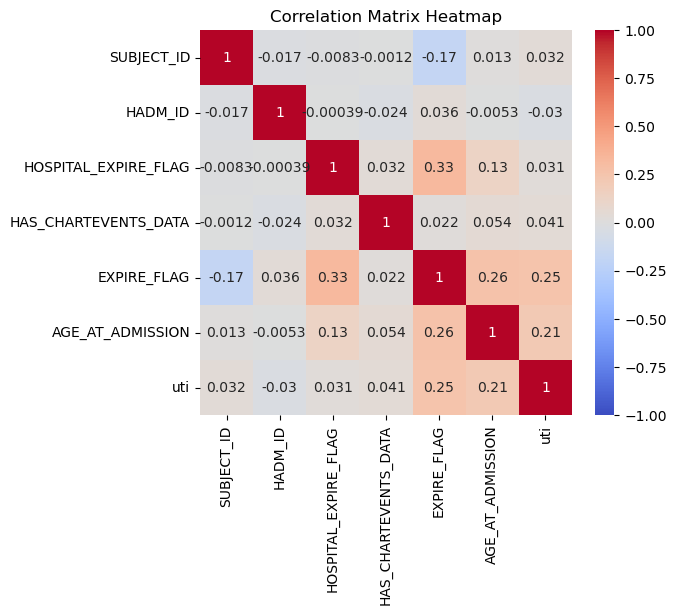

In [ ]:
columns_to_retain = ["SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME", "DEATHTIME", "ADMISSION_TYPE",
                     "ADMISSION_LOCATION", "DISCHARGE_LOCATION", "INSURANCE", "LANGUAGE", "RELIGION",
                     "MARITAL_STATUS", "ETHNICITY", "EDREGTIME", "EDOUTTIME", "DIAGNOSIS",
                     "HOSPITAL_EXPIRE_FLAG", "HAS_CHARTEVENTS_DATA", "admission_duration", "DEATH_STATUS",
                     "GENDER", "DOB", "DOD", "DOD_HOSP", "DOD_SSN", "EXPIRE_FLAG", "DEATH_HOSP",
                     "AGE_AT_ADMISSION", "uti"]

admission_icd_filtered = admission_icd_merged[columns_to_retain]

# compute correlation matrix
correlation_matrix = admission_icd_filtered.corr()

# plotting the correlation matrix using heatmap
plt.figure(figsize=(6,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Displaying the Exact Numbers
correlation_matrix

SUBJECT_ID   HADM_ID  HOSPITAL_EXPIRE_FLAG  \
SUBJECT_ID              1.000000 -0.016583             -0.008283   
HADM_ID                -0.016583  1.000000             -0.000389   
HOSPITAL_EXPIRE_FLAG   -0.008283 -0.000389              1.000000   
HAS_CHARTEVENTS_DATA   -0.001184 -0.023988              0.032350   
EXPIRE_FLAG            -0.174772  0.036473              0.325736   
AGE_AT_ADMISSION        0.013449 -0.005271              0.127891   
uti                     0.032122 -0.030401              0.030646   

                      HAS_CHARTEVENTS_DATA  EXPIRE_FLAG  AGE_AT_ADMISSION  \
SUBJECT_ID                       -0.001184    -0.174772          0.013449   
HADM_ID                          -0.023988     0.036473         -0.005271   
HOSPITAL_EXPIRE_FLAG              0.032350     0.325736          0.127891   
HAS_CHARTEVENTS_DATA              1.000000     0.022475          0.053870   
EXPIRE_FLAG                       0.022475     1.000000          0.263198   
AGE_AT_ADMISSION                  0.053870     0.263198          1.000000   
uti                               0.040610     0.254601          0.214049   

                           uti  
SUBJECT_ID            0.032122  
HADM_ID              -0.030401  
HOSPITAL_EXPIRE_FLAG  0.030646  
HAS_CHARTEVENTS_DATA  0.040610  
EXPIRE_FLAG           0.254601  
AGE_AT_ADMISSION      0.214049  
uti                   1.000000

**Preprocess timestamp data**

Machine learning models require numerical input and cannot handle date/time objects directly. To fix this, we'll need to convert these Timestamp columns to numerical representations. One common method is to convert them to the number of seconds since some reference point (like the UNIX timestamp).

In [ ]:
# display data types
print(admission_icd_merged.iloc[:, :30].dtypes)

SUBJECT_ID                           int64
HADM_ID                              int64
ADMITTIME                   datetime64[ns]
DISCHTIME                   datetime64[ns]
DEATHTIME                           object
ADMISSION_TYPE                      object
ADMISSION_LOCATION                  object
DISCHARGE_LOCATION                  object
INSURANCE                           object
LANGUAGE                            object
RELIGION                            object
MARITAL_STATUS                      object
ETHNICITY                           object
EDREGTIME                           object
EDOUTTIME                           object
DIAGNOSIS                           object
HOSPITAL_EXPIRE_FLAG                 int64
HAS_CHARTEVENTS_DATA                 int64
DEATH_STATUS                        object
admission_duration         timedelta64[ns]
GENDER                              object
DOB                         datetime64[ns]
DOD                                 object
DOD_HOSP   

In [ ]:
timestamp_cols = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'admission_duration']

reference_time = pd.Timestamp('1970-01-01')

for col in timestamp_cols:
    # Convert to datetime if necessary
    if admission_icd_merged[col].dtype == 'float64':
        # Assuming they are UNIX timestamps
        admission_icd_merged[col] = pd.to_datetime(admission_icd_merged[col], unit='s', errors='coerce')
    elif admission_icd_merged[col].dtype == 'object':
        admission_icd_merged[col] = pd.to_datetime(admission_icd_merged[col], errors='coerce')

    # Subtract reference_time only if the column dtype is datetime64[ns]
    if admission_icd_merged[col].dtype == 'datetime64[ns]':
        admission_icd_merged[col] = (admission_icd_merged[col] - reference_time).dt.total_seconds()


drop admission_duration in timedelta64[ns] format. We have admission_duration_days that represents the same thing.

In [ ]:
admission_icd_merged = admission_icd_merged.drop(columns='admission_duration')

In [ ]:
print(admission_icd_merged.iloc[:, :30].dtypes)

SUBJECT_ID                           int64
HADM_ID                              int64
ADMITTIME                          float64
DISCHTIME                          float64
DEATHTIME                          float64
ADMISSION_TYPE                      object
ADMISSION_LOCATION                  object
DISCHARGE_LOCATION                  object
INSURANCE                           object
LANGUAGE                            object
RELIGION                            object
MARITAL_STATUS                      object
ETHNICITY                           object
EDREGTIME                          float64
EDOUTTIME                          float64
DIAGNOSIS                           object
HOSPITAL_EXPIRE_FLAG                 int64
HAS_CHARTEVENTS_DATA                 int64
DEATH_STATUS                        object
GENDER                              object
DOB                                float64
DOD                                float64
DOD_HOSP                           float64
DOD_SSN    

**Handle missing values**

Random forest does not support input data with missing values.

In [ ]:
missing_values = admission_icd_merged.isnull().sum()
print(missing_values.iloc[0:30])

SUBJECT_ID                           0
HADM_ID                              0
ADMITTIME                            0
DISCHTIME                            0
DEATHTIME                          914
ADMISSION_TYPE                       0
ADMISSION_LOCATION                   0
DISCHARGE_LOCATION                   0
INSURANCE                            0
LANGUAGE                           400
RELIGION                             7
MARITAL_STATUS                     113
ETHNICITY                            0
EDREGTIME                          383
EDOUTTIME                          383
DIAGNOSIS                            1
HOSPITAL_EXPIRE_FLAG                 0
HAS_CHARTEVENTS_DATA                 0
DEATH_STATUS                         0
GENDER                               0
DOB                                  0
DOD                                530
DOD_HOSP                           716
DOD_SSN                            588
EXPIRE_FLAG                          0
DEATH_HOSP               

For categorical variable, replace NaN with 'missing_value'.

In [ ]:
admission_icd_merged['LANGUAGE'].fillna('missing_value', inplace=True)
admission_icd_merged['MARITAL_STATUS'].fillna('missing_value', inplace=True)

For the AGE_AT_ADMISSION column, replace NaN values with the median.

In [ ]:
median_age = admission_icd_merged['AGE_AT_ADMISSION'].median()
admission_icd_merged['AGE_AT_ADMISSION'].fillna(median_age, inplace=True)

For the death related columns, we already have DEATH_STATUS and EXPIRE_FLAG categorical variables, so we can drop them. EDREGTIME and EDOUTTIME can be dropped too.

In [ ]:
admission_icd_merged.drop(columns=['DEATHTIME', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EDREGTIME', 'EDOUTTIME'], inplace=True)

**One-hot encoding for all categorical variables.**

In [ ]:
encoded_df = pd.get_dummies(admission_icd_merged, columns=None, drop_first=False)

**Convert all feature names to strings before fitting to random forest.**

In [ ]:
encoded_df.columns = encoded_df.columns.astype(str)

**Remove SUBJECT_ID and HADM_ID before model training.**

In [ ]:
encoded_df = encoded_df.drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

In [ ]:
encoded_df

ADMITTIME     DISCHTIME  HOSPITAL_EXPIRE_FLAG  HAS_CHARTEVENTS_DATA  \
0    7.213467e+09  7.220847e+09                     0                     1   
1    4.497561e+09  4.498120e+09                     0                     1   
2    6.342106e+09  6.342494e+09                     0                     1   
3    5.211113e+09  5.211796e+09                     0                     1   
4    5.418181e+09  5.418475e+09                     0                     1   
..            ...           ...                   ...                   ...   
995  6.319930e+09  6.320478e+09                     0                     1   
996  5.504949e+09  5.505475e+09                     0                     1   
997  5.906815e+09  5.907575e+09                     0                     1   
998  5.883608e+09  5.884590e+09                     0                     1   
999  5.088345e+09  5.088582e+09                     0                     1   

              DOB  EXPIRE_FLAG  AGE_AT_ADMISSION  admission_duration_days  \
0    5.213808e+09            1              63.0                85.420833   
1    1.790122e+09            1              85.0                 6.468056   
2    4.524854e+09            0              57.0                 4.491667   
3   -4.256064e+09            1              65.0                 7.905556   
4    4.657738e+09            1              24.0                 3.408333   
..            ...          ...               ...                      ...   
995  4.386701e+09            0              61.0                 6.347222   
996  4.147114e+09            1              43.0                 6.081250   
997  3.303677e+09            0              82.0                 8.793750   
998  5.147626e+09            0              23.0                11.371528   
999  4.476125e+09            0              19.0                 2.742361   

     nan  00845, Int inf clstrdium dfcile  0088, Viral enteritis NOS  \
0    1.0                              0.0                        0.0   
1    0.0                              0.0                        0.0   
2    0.0                              0.0                        0.0   
3    0.0                              0.0                        0.0   
4    0.0                              0.0                        0.0   
..   ...                              ...                        ...   
995  0.0                              0.0                        0.0   
996  0.0                              0.0                        0.0   
997  0.0                              0.0                        0.0   
998  0.0                              0.0                        0.0   
999  0.0                              0.0                        0.0   

     0380, Streptococcal septicemia  03810, Staphylcocc septicem NOS  \
0                               0.0                              1.0   
1                               0.0                              0.0   
2                               0.0                              0.0   
3                               0.0                              0.0   
4                               0.0                              0.0   
..                              ...                              ...   
995                             0.0                              0.0   
996                             0.0                              0.0   
997                             0.0                              0.0   
998                             0.0                              0.0   
999                             0.0                              0.0   

     03811, Meth susc Staph aur sept  03812, MRSA septicemia  \
0                                0.0                     0.0   
1                                0.0                     0.0   
2                                0.0                     0.0   
3                                0.0                     0.0   
4                                0.0                     0.0   
..                  

### Use ClinicalBERT model by Hugging Face to process the 'noteevents' data.

In [ ]:
# # Compute the lengths of the TEXT field
# noteevents['text_length'] = noteevents['TEXT'].str.len()

# # Find the maximum length
# max_length = noteevents['text_length'].max()

# # Find the average length
# avg_length = noteevents['text_length'].mean()

# print(f"Maximum length of TEXT: {max_length}")
# print(f"Average length of TEXT: {avg_length:.2f}")

Maximum length of TEXT: 55728
Average length of TEXT: 1826.01


Use 2500 max length

In [ ]:
#! pip install transformers torch

In [ ]:
#from transformers import BertTokenizer, BertModel

# Load the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# model = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
# # Tokenize and process the notes
# def embed_text(text):
#     # Tokenize text (add special tokens and pad/truncate)
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=2500)

#     # Get embeddings
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Get the [CLS] token embeddings which can be used as sentence embeddings
#     embeddings = outputs.last_hidden_state[:, 0, :].numpy()

#     return embeddings

# noteevents['embeddings'] = noteevents['TEXT'].apply(embed_text)


### Autoencoder followed by UMAP to visualise latent space

1. Preprocess the Data: Most columns in the admission_merged table seem to be of a non-numeric type. We'll need to preprocess the data to convert non-numeric fields into a format suitable for training. One of the common techniques is to use one-hot encoding for categorical data. However, be cautious with date fields and fields with a large number of unique values, as one-hot encoding might not be the best choice for them.

2. Build an Autoencoder: We'll use Keras for this.

3. Train the Autoencoder.

4. Extract Latent Features.

5. Apply UMAP.

6. Visualize the Results.

Autoencoder example notebook: https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

TSNE

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

In [ ]:
# extra code – beautifies the previous diagram

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
#save_fig("visualization_plot")
plt.show()

### Clustering

<div class="alert alert-block alert-info">
<h2>Model Training and Evaluation</h2>
</div>

train test split

In [ ]:
from sklearn.model_selection import train_test_split

X = encoded_df.drop('uti', axis=1)
y = encoded_df['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pip3 install lightgbm
!pip3 install featurewiz

SyntaxError: invalid syntax (1560283467.py, line 1)

In [ ]:
from featurewiz import featurewiz

ModuleNotFoundError: No module named 'featurewiz'

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Visualizing the tree

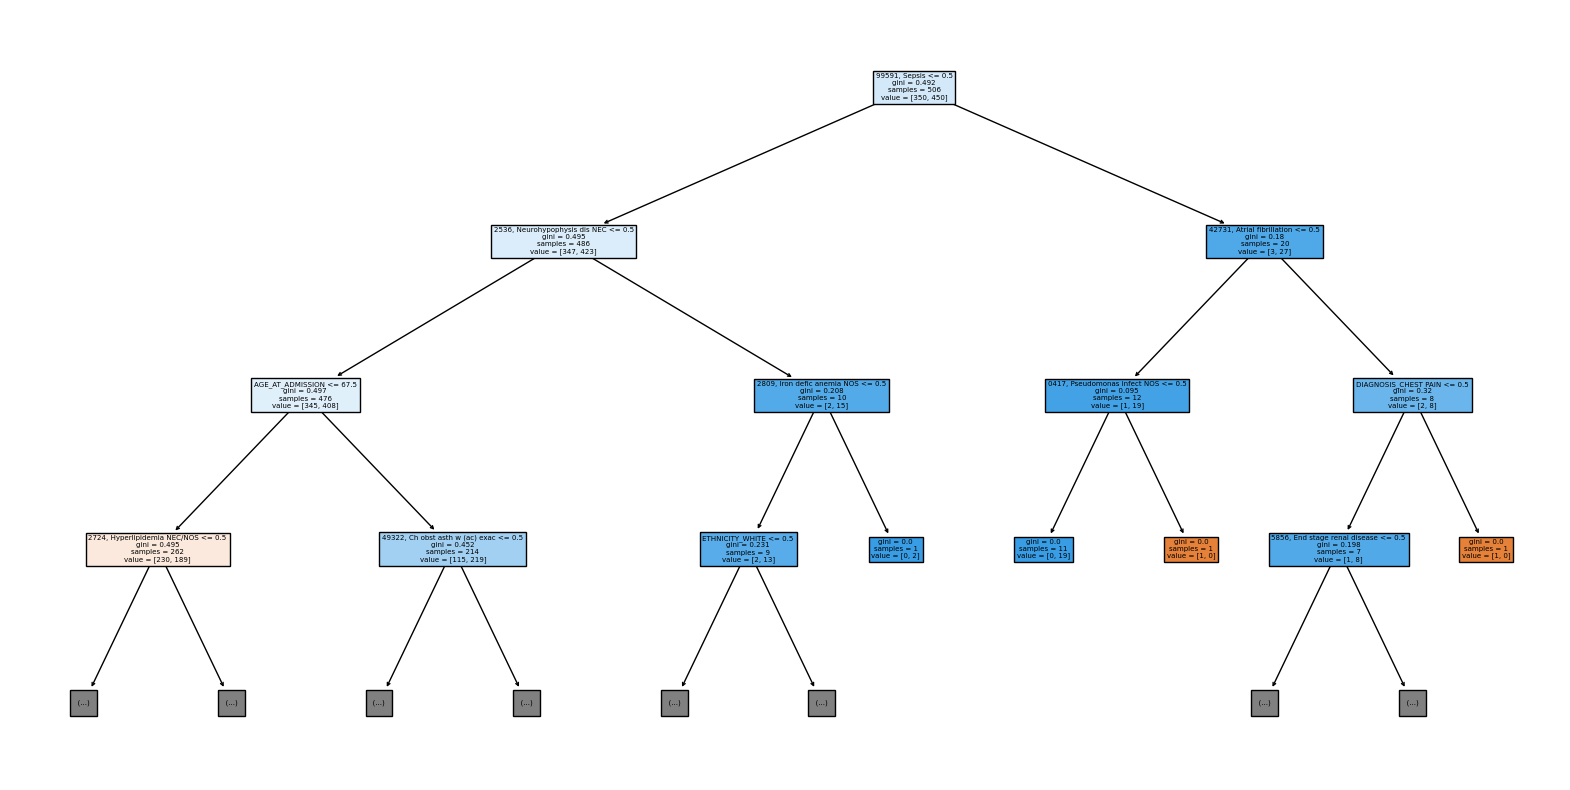

In [ ]:
from sklearn.tree import plot_tree

# Visualizing the first decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=3, feature_names=X.columns)
plt.show()

An individual decision tree's visualization highlights the features at the top nodes because they resulted in the largest decrease in impurity for that specific tree. However, this doesn't mean those features consistently had the highest decrease in impurity across all trees in the forest.

Feature Importance:

In Random Forest, feature importance for a variable is typically calculated as the total decrease in node impurity (usually measured by the Gini impurity or entropy) that is brought by that feature, averaged over all trees.

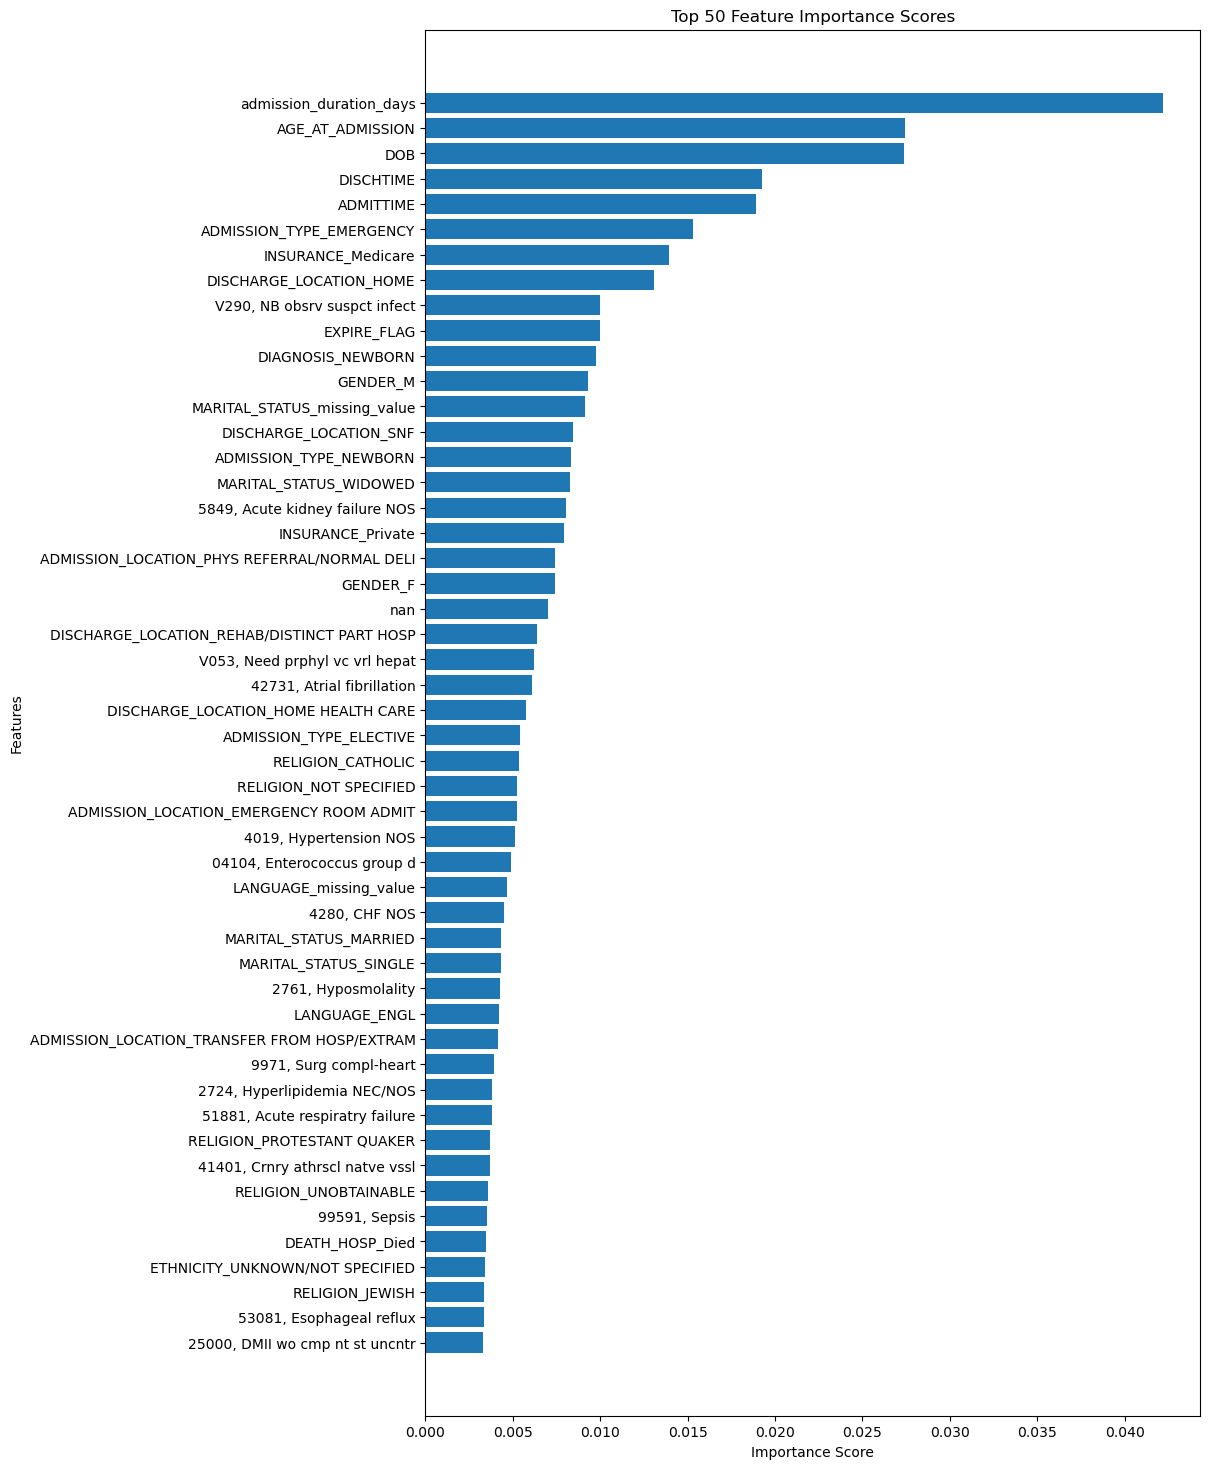

In [ ]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


**Model Evaluation**

classification report

In [ ]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.59      0.64        88
         1.0       0.71      0.79      0.75       112

    accuracy                           0.70       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.70      0.70       200



confusion matrix

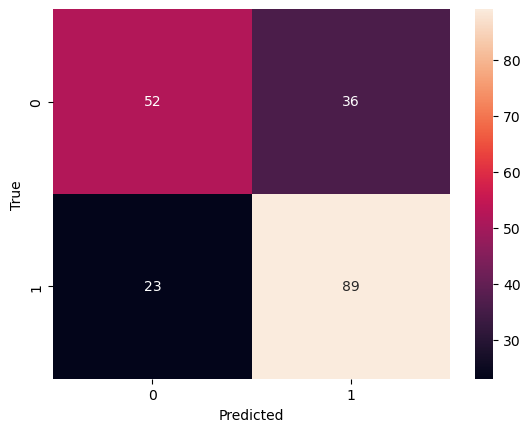

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Risk Scores

In [ ]:
# Predict probabilities
probabilities = rf.predict_proba(X_test)

# Extract uti risk scores
uti_risk_scores = probabilities[:, 1]
uti_risk_scores_percentage = uti_risk_scores * 100

In [ ]:
# check total number of admissions (test size = 200)
total_admissions_in_histogram = len(uti_risk_scores)
print(f"Total number of admissions in the histogram: {total_admissions_in_histogram}")

Total number of admissions in the histogram: 200


Histogram of risk score

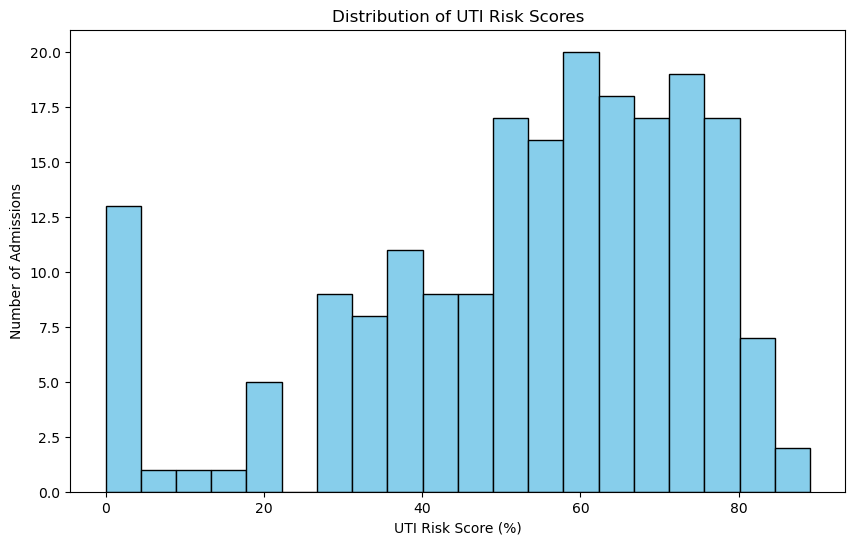

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(uti_risk_scores_percentage, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('UTI Risk Score (%)')
plt.ylabel('Number of Admissions')
plt.title('Distribution of UTI Risk Scores')
plt.show()

Differentiate and see histograms separately for actual UTI and non-UTI patients

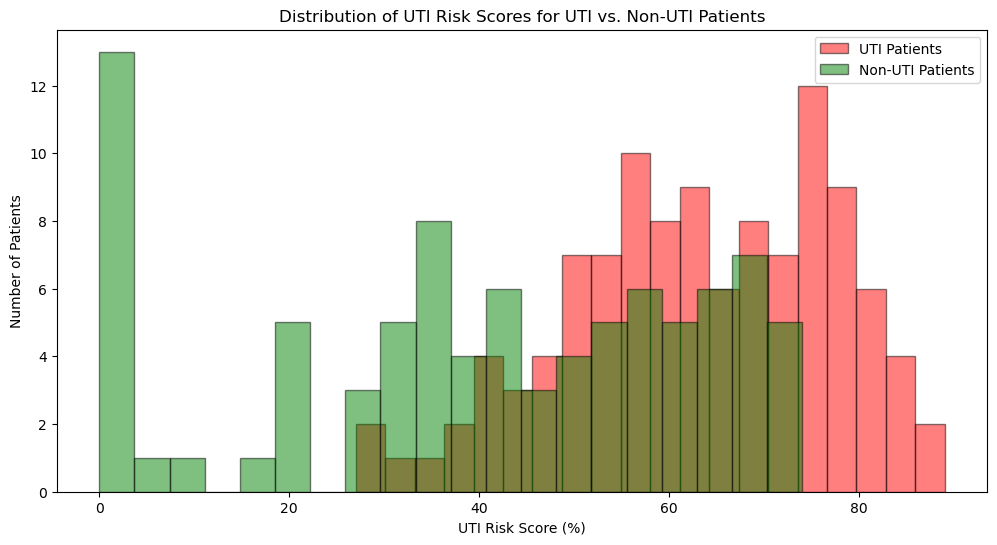

In [ ]:
uti_scores = uti_risk_scores_percentage[y_test == 1]
non_uti_scores = uti_risk_scores_percentage[y_test == 0]

plt.figure(figsize=(12,6))

# Histogram for UTI patients
plt.hist(uti_scores, bins=20, color='red', alpha=0.5, label='UTI Patients', edgecolor='black')

# Histogram for non-UTI patients
plt.hist(non_uti_scores, bins=20, color='green', alpha=0.5, label='Non-UTI Patients', edgecolor='black')

plt.xlabel('UTI Risk Score (%)')
plt.ylabel('Number of Patients')
plt.title('Distribution of UTI Risk Scores for UTI vs. Non-UTI Patients')
plt.legend()
plt.show()


Boxplot of risk score

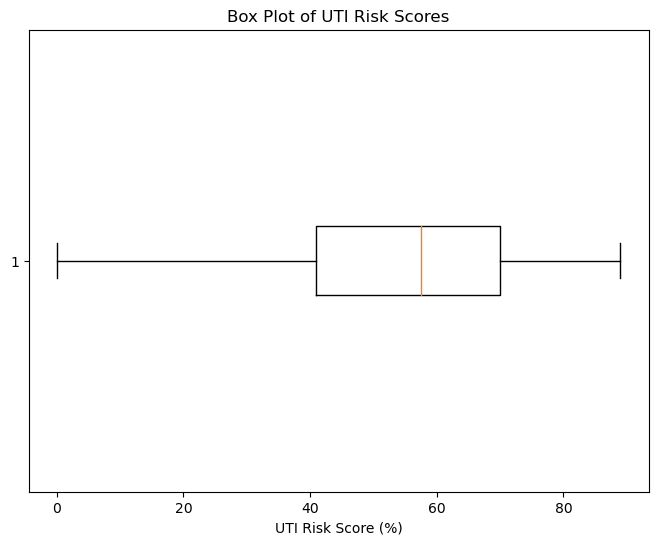

In [ ]:
plt.figure(figsize=(8,6))
plt.boxplot(uti_risk_scores_percentage, vert=False)
plt.xlabel('UTI Risk Score (%)')
plt.title('Box Plot of UTI Risk Scores')
plt.show()

Risk Categories Visualization

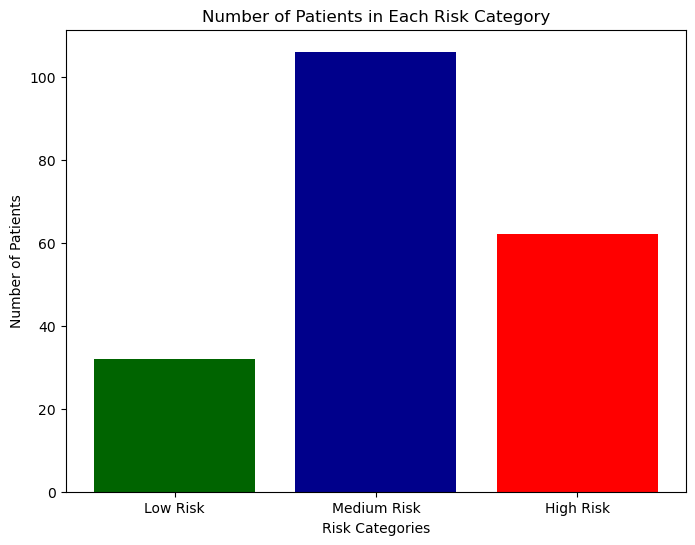

In [ ]:
categories = ['Low Risk', 'Medium Risk', 'High Risk']
counts = [
    sum(uti_risk_scores_percentage <= 33),
    sum((uti_risk_scores_percentage > 33) & (uti_risk_scores_percentage <= 66)),
    sum(uti_risk_scores_percentage > 66)
]

plt.figure(figsize=(8,6))
plt.bar(categories, counts, color=['darkgreen', 'darkblue', 'red'])
plt.xlabel('Risk Categories')
plt.ylabel('Number of Patients')
plt.title('Number of Patients in Each Risk Category')
plt.show()


ROC Curve

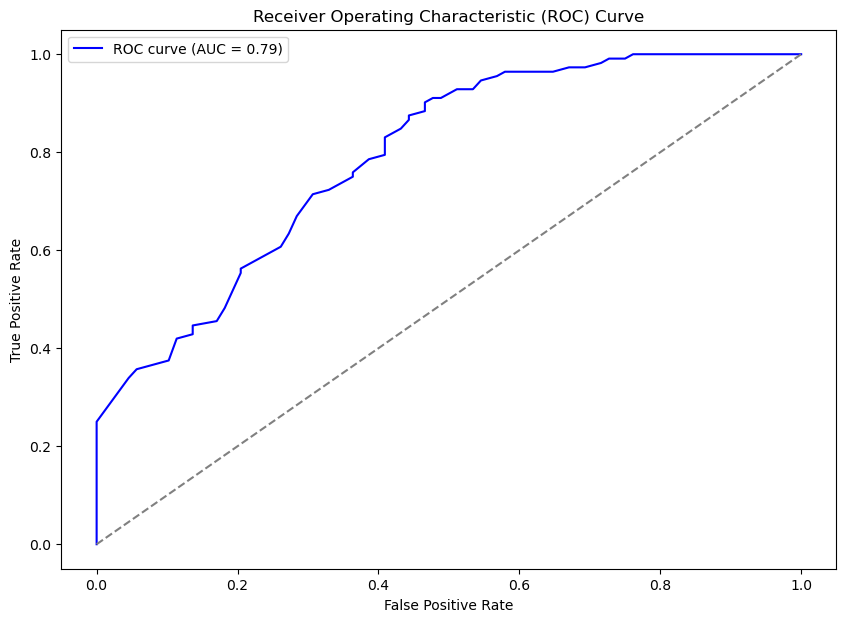

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, uti_risk_scores_percentage/100)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc_score(y_test, uti_risk_scores_percentage/100)))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Codes from Shiv

In [ ]:
# diagnosis_icd[diagnosis_icd['LONG_TITLE'].apply(lambda x:True if 'urinary tract infection' in x.lower() else False)]

In [ ]:
# import pandas as pd
# import numpy as np
# import sweetviz

# admissions= pd.read_csv("data/ADMISSIONS.csv")
# icd = pd.read_csv('data/DIAGNOSES_ICD.csv')
# icd_desc = pd.read_csv('data/D_ICD_DIAGNOSES.csv')
# #Bloods
# bloods = pd.read_csv('data/LABEVENTS.csv')

# #microbiology
# micro = pd.read_csv('data/MICROBIOLOGYEVENTS.csv')

# lab_items = pd.read_csv('data/D_LABITEMS.csv')
# items = lab_items = pd.read_csv('data/D_ITEMS.csv')

# final_df = pd.merge(bloods, lab_items, on ='ITEMID')
# micro_merged = pd.merge(micro, items, left_on='SPEC_ITEMID', right_on='ITEMID')
# icd_merged = pd.merge(icd, icd_desc, on='ICD9_CODE')
# out_df = sweetviz.analyze(admissions[['ETHNICITY','DIAGNOSIS','SUBJECT_ID']])
# uti_icd9 = icd_merged[icd_merged['LONG_TITLE'].apply(lambda x:\
#                                                      'urinary tract' in x.lower())]

# np.random.seed(0)
# hadm_uti = list(set(uti_icd9['HADM_ID'].sample(100)))

Neo4j

In [ ]:
# LOAD CSV WITH HEADERS FROM 'file:///uti.csv' as uti
# MERGE (a:Admission{id:uti.HADM_ID})
# MERGE (icd:ICD{id:uti.SHORT_TITLE})
# MERGE (a)-[:HAS]->(icd)

# MATCH (n:ICD)
# WHERE n.id="Urin tract infection NOS"
# RETURN (n)

# MATCH (a:Admission)-[r:HAS]->(icd:ICD{id:'Urin tract infection NOS'})
# MATCH (a)-[r2:HAS]->(otherICDs)
# WHERE NOT (icd=otherICDs)
# RETURN otherICDs,COUNT(r2) as popularity
# ORDER BY popularity DESC

**30/8 RPH Large Language Model**

Run this in terminal:

ssh -L localhost:5000:localhost:5000 jia@146.118.68.235

In [ ]:
import requests
import re

# For local streaming, the websockets are hosted without ssl - http://
HOST = 'localhost:5000'
URI = f'http://{HOST}/api/v1/generate'

# For reverse-proxied streaming, the remote will likely host with ssl - https://
# URI = 'https://your-uri-here.trycloudflare.com/api/v1/generate'


def run(prompt,disease):
    prompt = prompt.replace('$disease',disease)
    request = {
        'prompt': prompt,
        'max_new_tokens': 250,
        'temperature': 10.0,
        'top_p': 0.1,
        'length_penalty': 5,
        'early_stopping': True,
        'seed': 0,
    }

    response = requests.post(URI, json=request)
    print(response.json()['results'][0]['text'], disease)

    return response.json()['results'][0]['text']


In [ ]:
# if __name__ == '__main__':
#   prompt = '''
#     [INST] <<SYS>>
#     Answer the questions.
# You are a medical expert. Is there a direct relationship between the following and diseases of the lungs?
#     Return Yes or No succinctly.
#     <</SYS>>
#     Input
#     $disease
#     [/INST]
#     '''
# run(prompt,'pneumonia')


# import pandas as pd
# df = pd.read_csv('./data/ADMISSIONS.csv')
# df_new = df.iloc[20:60].apply(lambda x:run(prompt,x['DIAGNOSIS']),axis=1)

Diseases to focus:

- I80 deep vein thrombosis
- N39 / 5990 UTI
- pneumonia